# Starting base for interpolation
Here the models that I will use for interpolation are trained, which will be trained on a single site and will go into free run on the same
Here the following tests will be performed:
- freeRun on n weeks where the (n-m)th week is the actual one where there is free run
- simple prediction on (n-m)th weeks and then freeRun

In [1]:
import os
from IPython.display import display, Markdown

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # disable info log from tensorflow


import tensorflow as tf
from modules.Imputation import (
    ModelFactory,
    Imputation,
    fit_model,
    freeze_not_dense_layer,
)
from modules.Plotter import GeneralPlotter
from modules.DatasetWrapper import Dataset, Log
from modules.TrainOnOneSite import Trainer

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

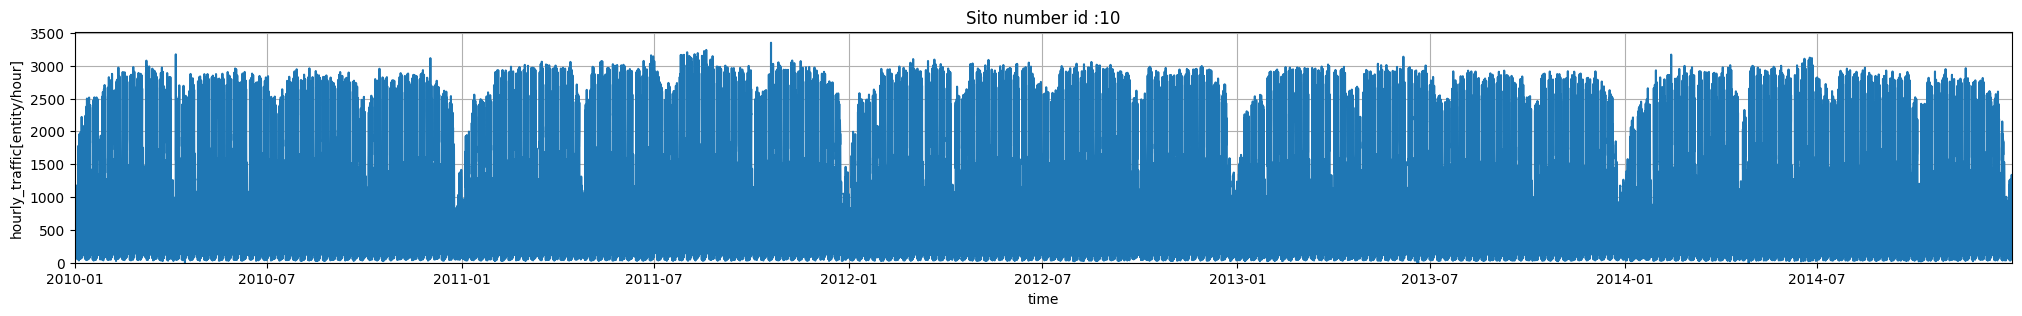

mean       std       min       25%       50%  \
hourly_traffic        0.548256  0.427252  0.000000  0.134444  0.472222   
temperature_2m        0.833086  0.301616  0.117000  0.612000  0.774500   
apparent_temperature  0.721823  0.344139 -0.049737  0.465404  0.656857   
relative_humidity_2m  0.657317  0.197985  0.081371  0.516910  0.679468   
precipitation         0.010049  0.049863  0.000000  0.000000  0.000000   
wind_speed_10m        1.068027  0.514500  0.000000  0.686417  1.012845   
cloud_cover           0.338667  0.311726  0.000000  0.030000  0.288000   

                           75%       max  
hourly_traffic        0.882778  1.861111  
temperature_2m        1.004500  2.019500  
apparent_temperature  0.925835  2.071331  
relative_humidity_2m  0.820077  1.000000  
precipitation         0.000000  1.560000  
wind_speed_10m        1.399428  3.755674  
cloud_cover           0.558000  1.000000

Site type: SIGNALISED_4_WAY_INTERSECTION


In [2]:
Base_Site = 10
data = Dataset()
_ = data.select_site(Base_Site)

In [3]:
X_col = Trainer.NEW_X_FEATURES
input_len = Trainer.NEW_X_WINDOWS
print(f"input_len={input_len}\nx_features={X_col}")

workspace = "Imputation_models"

Train_Site, Validation_Site, Test_Site = data.split_and_get_generators(
    X_col=X_col, input_size=input_len
)
trainer = Trainer(Train_Site, Validation_Site, Test_Site, workspace)

input_len=13
x_features=['hourly_traffic', 'hour_of_day(sin)', 'hour_of_day(cos)', 'day_of_week(sin)', 'day_of_week(cos)', 'holiday', 'temperature_2m', 'apparent_temperature']


In [5]:
def restore_model() :
    models = {}

    model = tf.keras.models.load_model("models/linear.keras")
    model.name ="Lineare"
    models[model.name] = model

    model = tf.keras.models.load_model("models/Conv1D.keras")
    model.name = "Conv1D"
    models["Conv1D"] = model

    model = tf.keras.models.load_model("models/GRU.keras")
    model.name = "GRU"
    models[model.name] = model

    model = tf.keras.models.load_model("models/simple_LSTM.keras")
    model.name = "un_layer_LSTM"
    models[model.name] = model
    
    model = tf.keras.models.load_model("models/Best_model_on1Site.keras")
    model.name = "Stacked_LSTM"
    models[model.name] = model

    return models
restore_model() 

{'Lineare': <Sequential name=Lineare, built=True>,
 'Conv1D': <Sequential name=Conv1D, built=True>,
 'GRU': <Sequential name=GRU, built=True>,
 'un_layer_LSTM': <Sequential name=un_layer_LSTM, built=True>,
 'Stacked_LSTM': <Sequential name=Stacked_LSTM, built=True>}

## Interpolazione

In [6]:
week = 7 * 24
compute_on = range(week * 4, week * 7 + Test_Site.input_width)
range_plot = range(0, 24 * 14)

### On the same site as the Train

In [6]:
imputer_same_site = Imputation(Test_Site, workspace=workspace)

# Estrapolo solo la parte del free run
gen_cut_same_site = Test_Site.copy()
gen_cut_same_site.df = Test_Site.df[compute_on.start : compute_on.stop].reset_index(
    drop=True
)
gen_cut_same_site.n = len(gen_cut_same_site.df)

#### Free Run starting exactly from the hole
I take the test set, extract from it only the weeks in which I would have the hole

---

Linear:


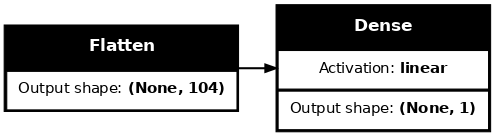

Free-Run: 100%|██████████| 504/504 [00:09<00:00, 53.97it/s]


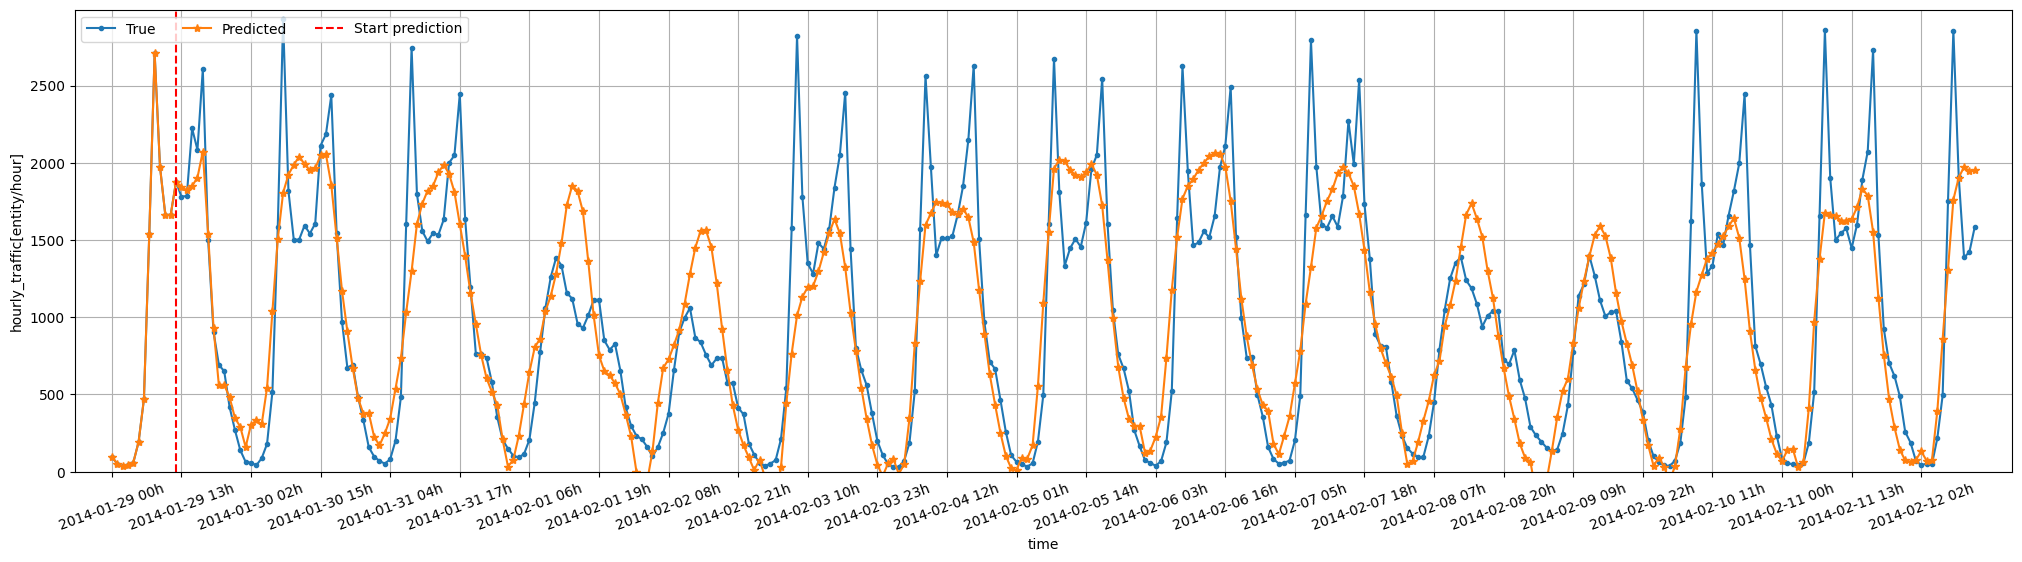

mean_squared_error: 0.0490(0.2214) - mean_absolute_error: 0.1527
DeNorm_mean_squared_error: 158912.6562(398.6385) - DeNorm_mean_absolute_error: 274.9371


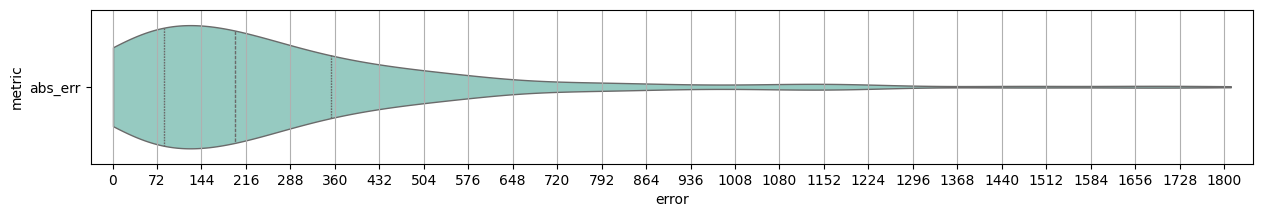

mean         std       min        25%         50%         75%  \
error  274.937083  288.942698  0.812325  84.010426  197.859239  352.998738   

               max  
error  1810.749588

{'mean_squared_error': 81096.43, 'mean_absolute_error': 199.9807}


---

cnn_1d:


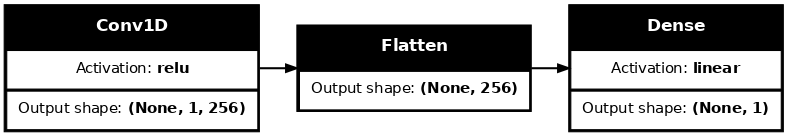

Free-Run: 100%|██████████| 504/504 [00:08<00:00, 57.68it/s]


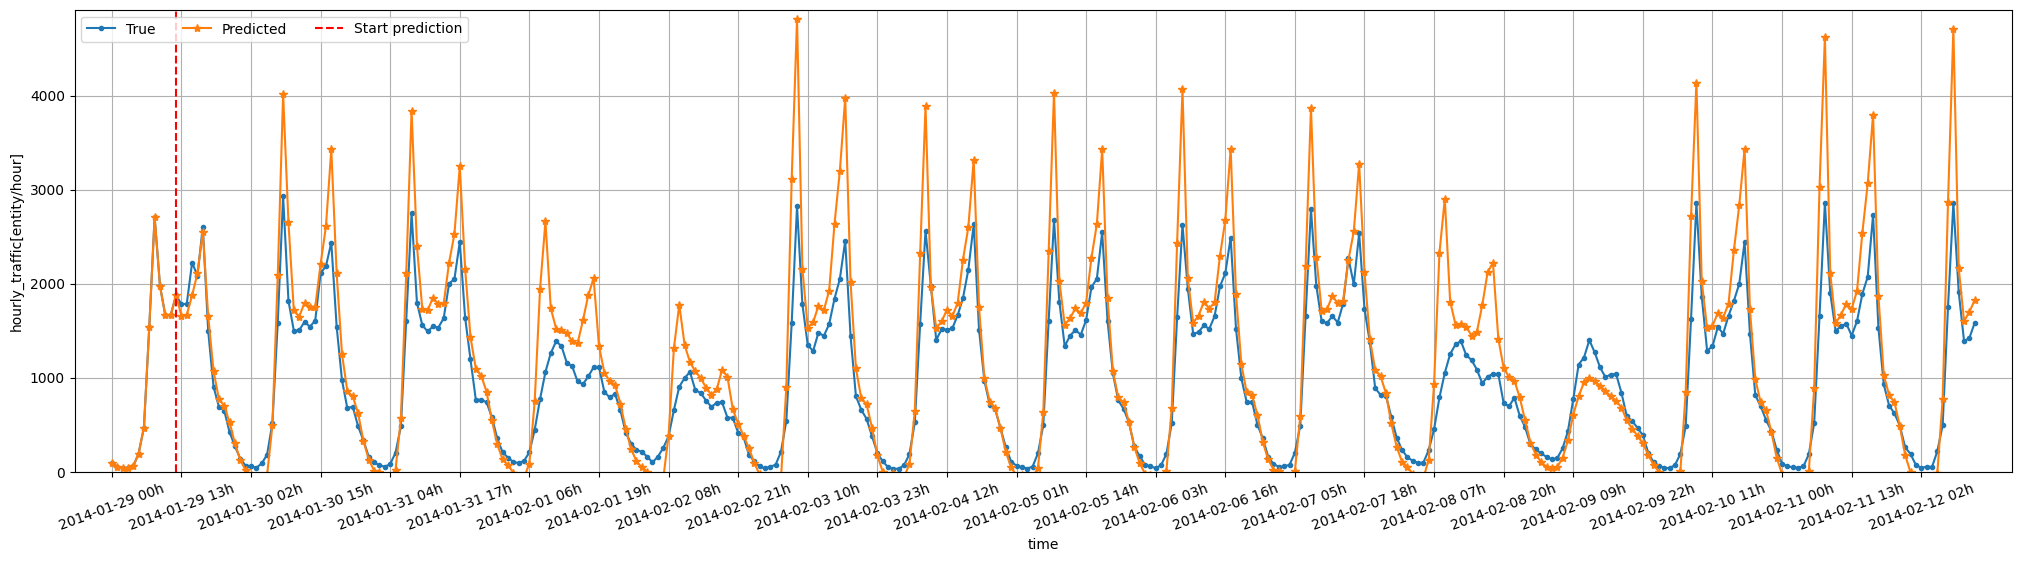

mean_squared_error: 0.0700(0.2646) - mean_absolute_error: 0.1709
DeNorm_mean_squared_error: 226853.4219(476.2913) - DeNorm_mean_absolute_error: 307.6752


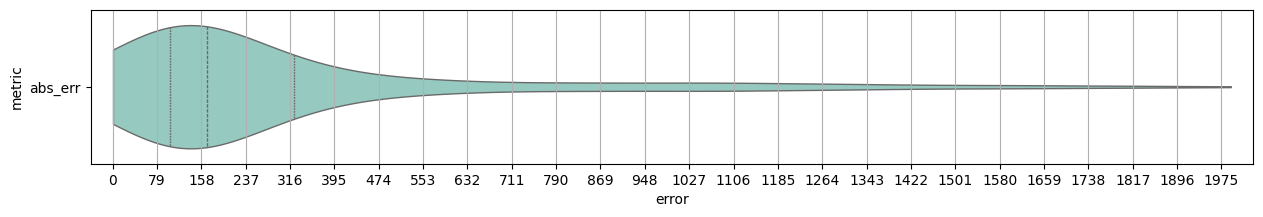

mean         std       min         25%         50%         75%  \
error  307.675157  363.939903  0.619366  102.865341  168.914077  323.818996   

               max  
error  1991.807297

{'mean_squared_error': 13430.453, 'mean_absolute_error': 83.1296}


---

LSTM_1_Layer:


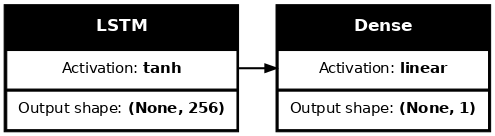

Free-Run: 100%|██████████| 504/504 [00:14<00:00, 35.90it/s]


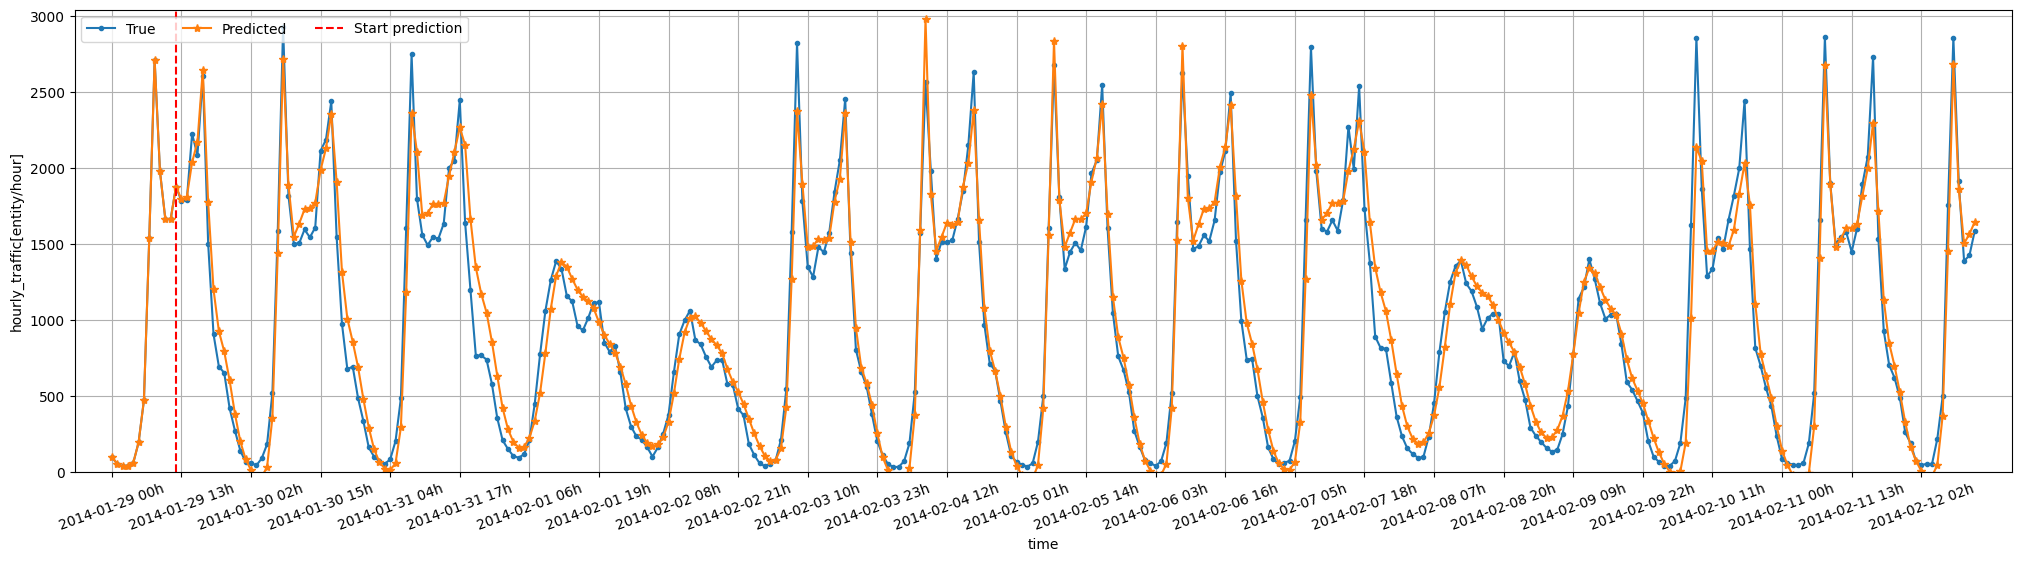

mean_squared_error: 0.0088(0.0938) - mean_absolute_error: 0.0711
DeNorm_mean_squared_error: 28407.7656(168.5460) - DeNorm_mean_absolute_error: 128.0252


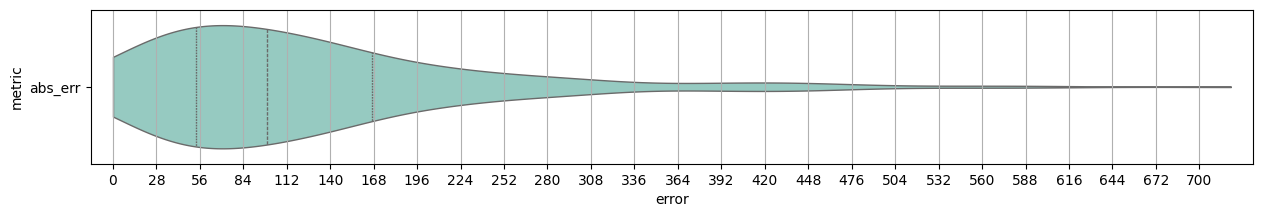

mean         std       min        25%       50%         75%  \
error  128.02516  109.732472  0.069092  53.517232  99.05279  166.707098   

              max  
error  720.267468

{'mean_squared_error': 12984.631, 'mean_absolute_error': 78.146}


---

Return_Sequenze:


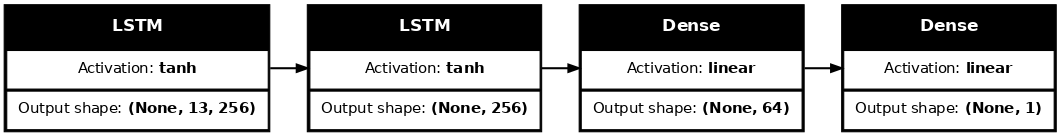

Free-Run: 100%|██████████| 504/504 [00:48<00:00, 10.42it/s]


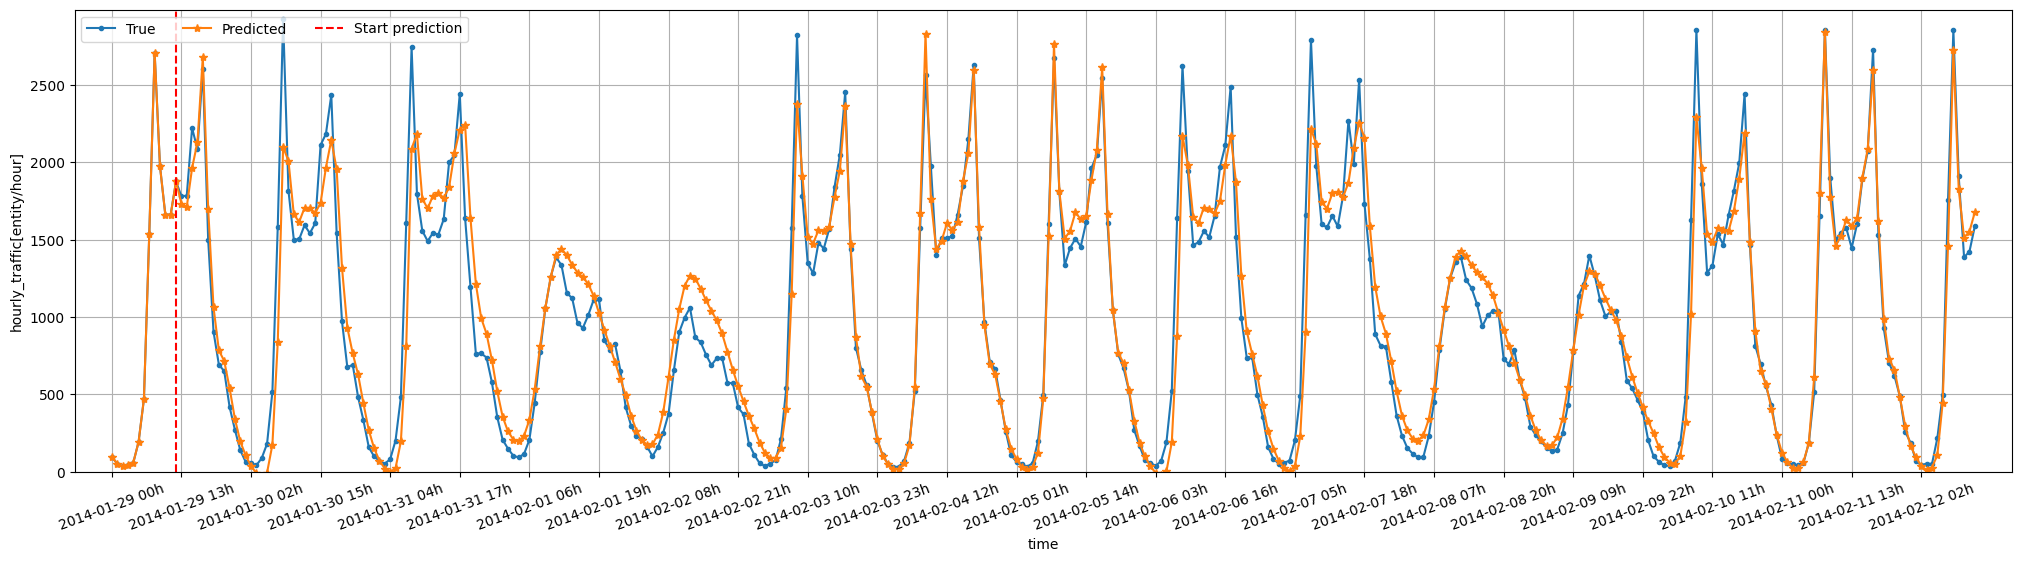

mean_squared_error: 0.0096(0.0980) - mean_absolute_error: 0.0659
DeNorm_mean_squared_error: 31083.8496(176.3061) - DeNorm_mean_absolute_error: 118.5910


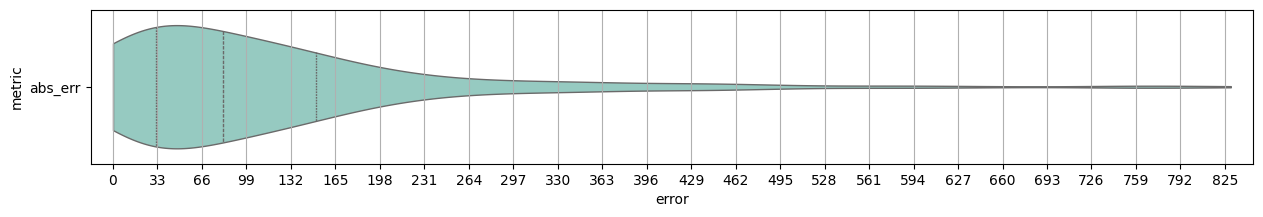

mean         std       min        25%        50%         75%  \
error  118.591019  130.590426  0.132786  31.992628  82.003802  150.445483   

              max  
error  829.354767

{'mean_squared_error': 10583.579, 'mean_absolute_error': 72.2369}


---

GRU_1_Layer:


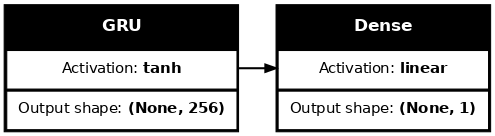

Free-Run: 100%|██████████| 504/504 [00:14<00:00, 35.60it/s]


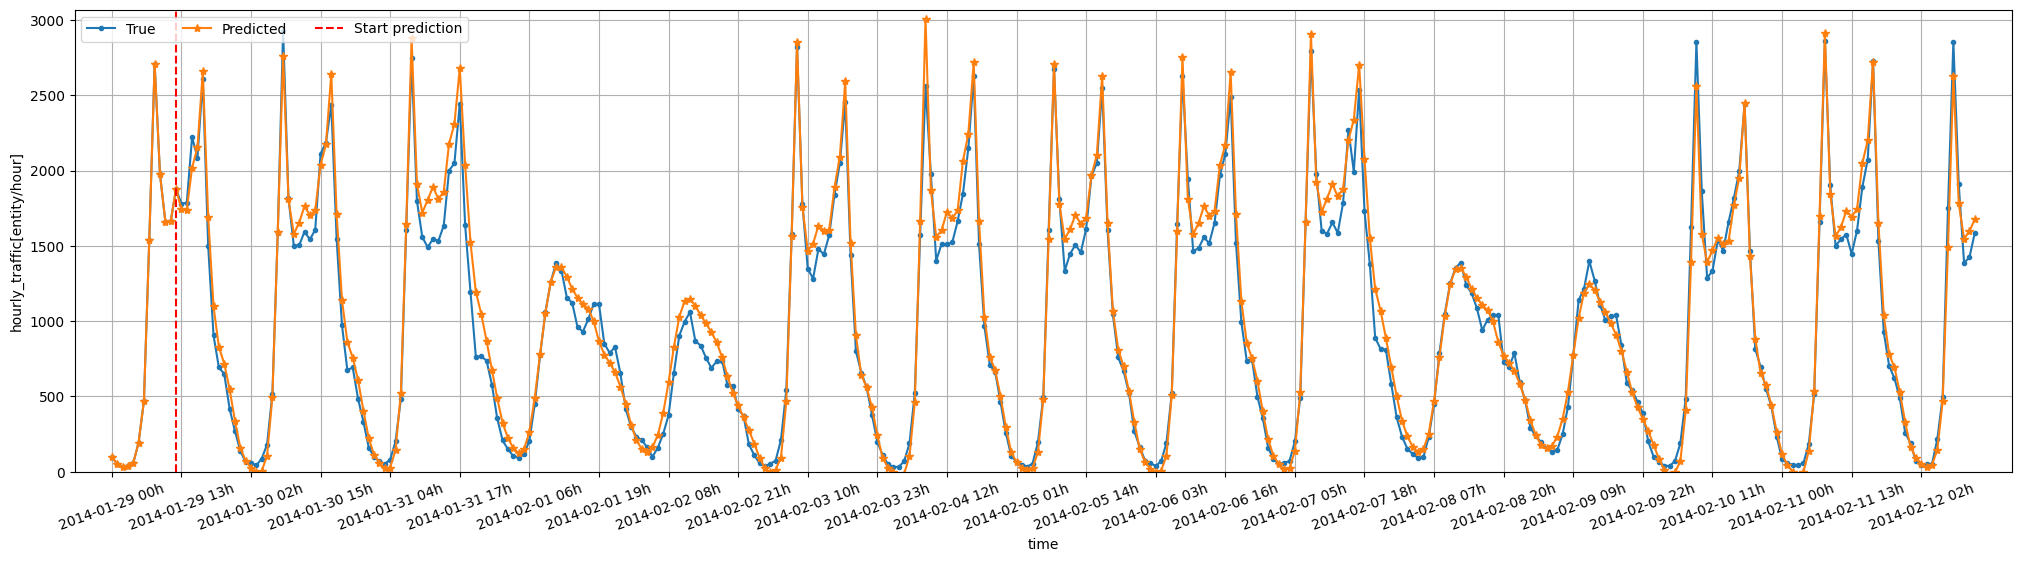

mean_squared_error: 0.0050(0.0707) - mean_absolute_error: 0.0513
DeNorm_mean_squared_error: 16182.1035(127.2089) - DeNorm_mean_absolute_error: 92.4189


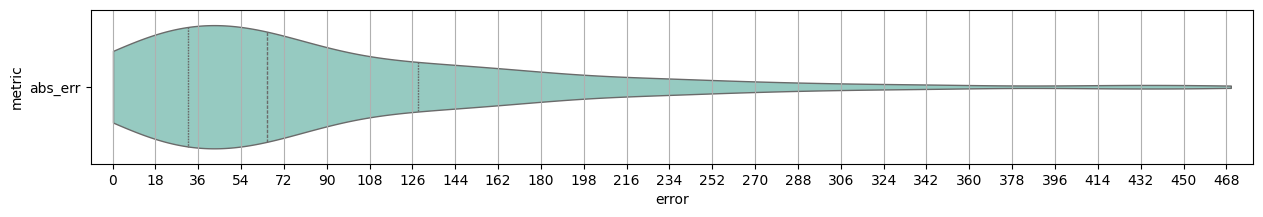

mean        std       min        25%        50%         75%  \
error  92.418943  87.498765  0.183119  31.829457  64.917187  128.485857   

              max  
error  469.863224

{'mean_squared_error': 10098.506, 'mean_absolute_error': 68.2032}


---

Bidirectional_LSTM:


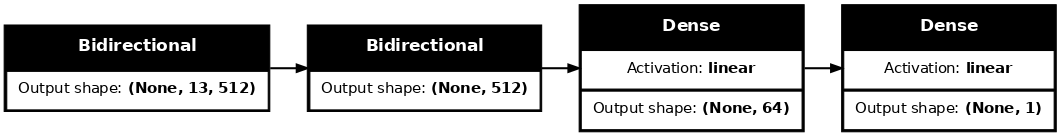

Free-Run: 100%|██████████| 504/504 [01:12<00:00,  6.98it/s]


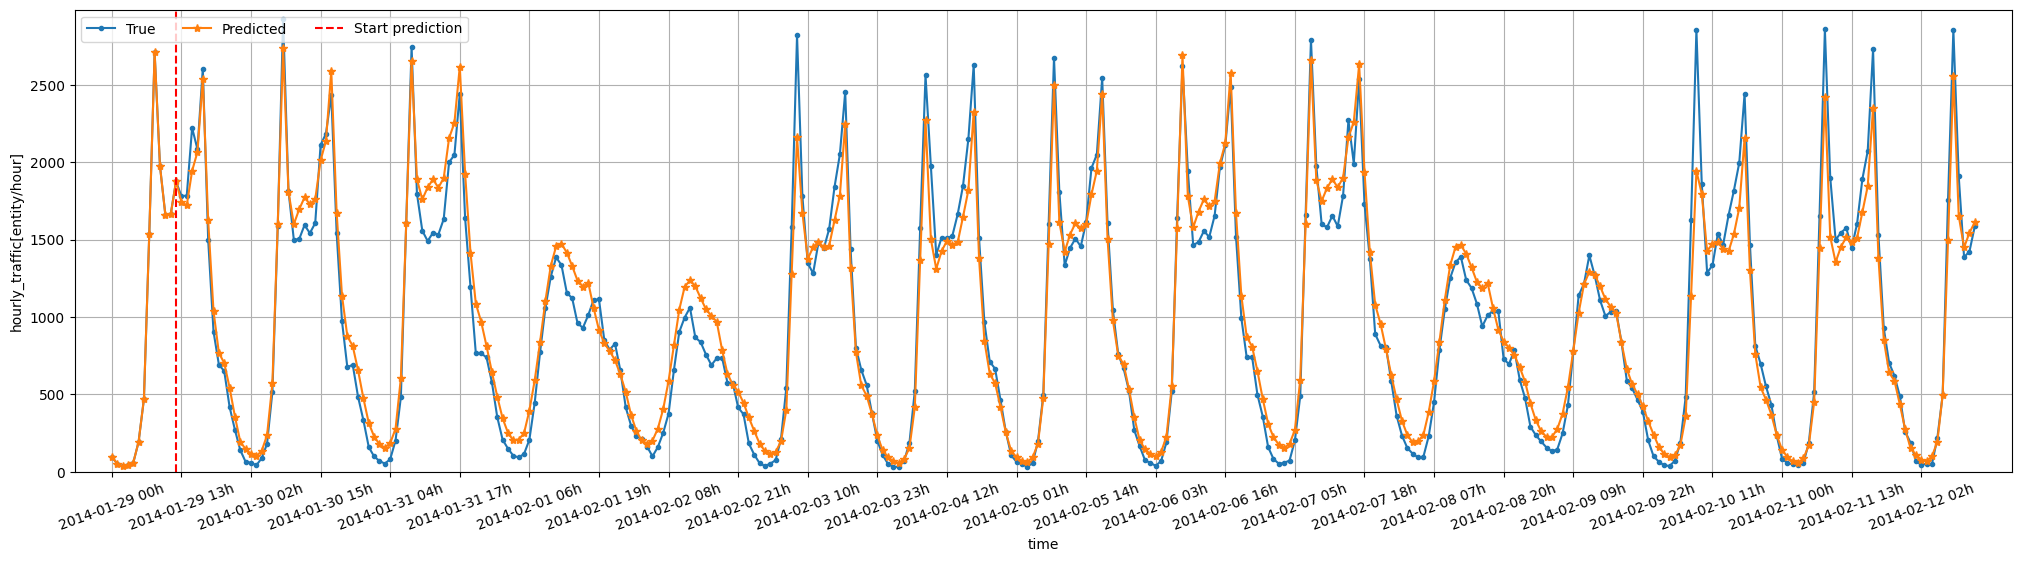

mean_squared_error: 0.0077(0.0877) - mean_absolute_error: 0.0655
DeNorm_mean_squared_error: 24807.0039(157.5024) - DeNorm_mean_absolute_error: 117.9028


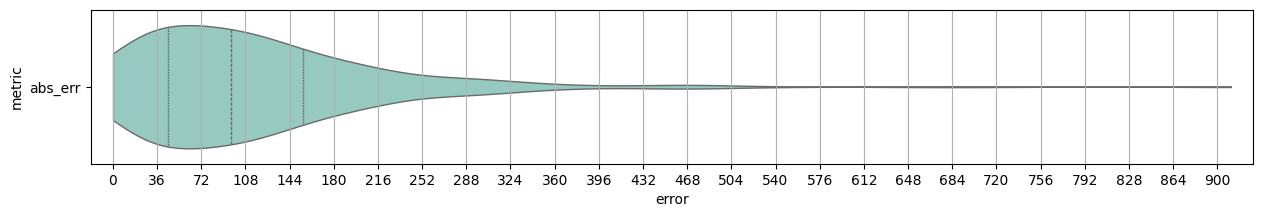

mean         std       min       25%        50%         75%  \
error  117.902842  104.535187  0.109135  45.20162  96.495707  154.690391   

              max  
error  910.955792

{'mean_squared_error': 9385.52, 'mean_absolute_error': 67.8632}


In [8]:
# log = restore_model()
log = restore_model()
for key, model in log.items():
    display(Markdown("---"))
    print(f"\033[01m{key}\033[0m:")
    display(
        tf.keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=False,
            rankdir="LR",
            dpi=75,
            show_layer_activations=True,
        )
    )

    path = f"img/{workspace}/{model.name}/"
    os.makedirs(path, exist_ok=True)
    
    _ = Trainer.free_run_with_plots(
        model,
        gen_cut_same_site,
        -1,
        range_plot,
        folder=path + f"site_{Base_Site}_start_on_hole_",
    )
    print(gen_cut_same_site.compute_metrics(model.predict(gen_cut_same_site, verbose = 0),scale_factor=1800))

del log

#### Doing simple prediction + Free Run

A simple prediction is made over n weeks **without resetting the state** followed by a free run over m weeks

---

Linear:


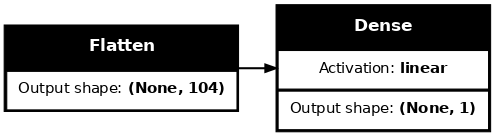

Free-Run: 100%|██████████| 504/504 [00:03<00:00, 148.52it/s]


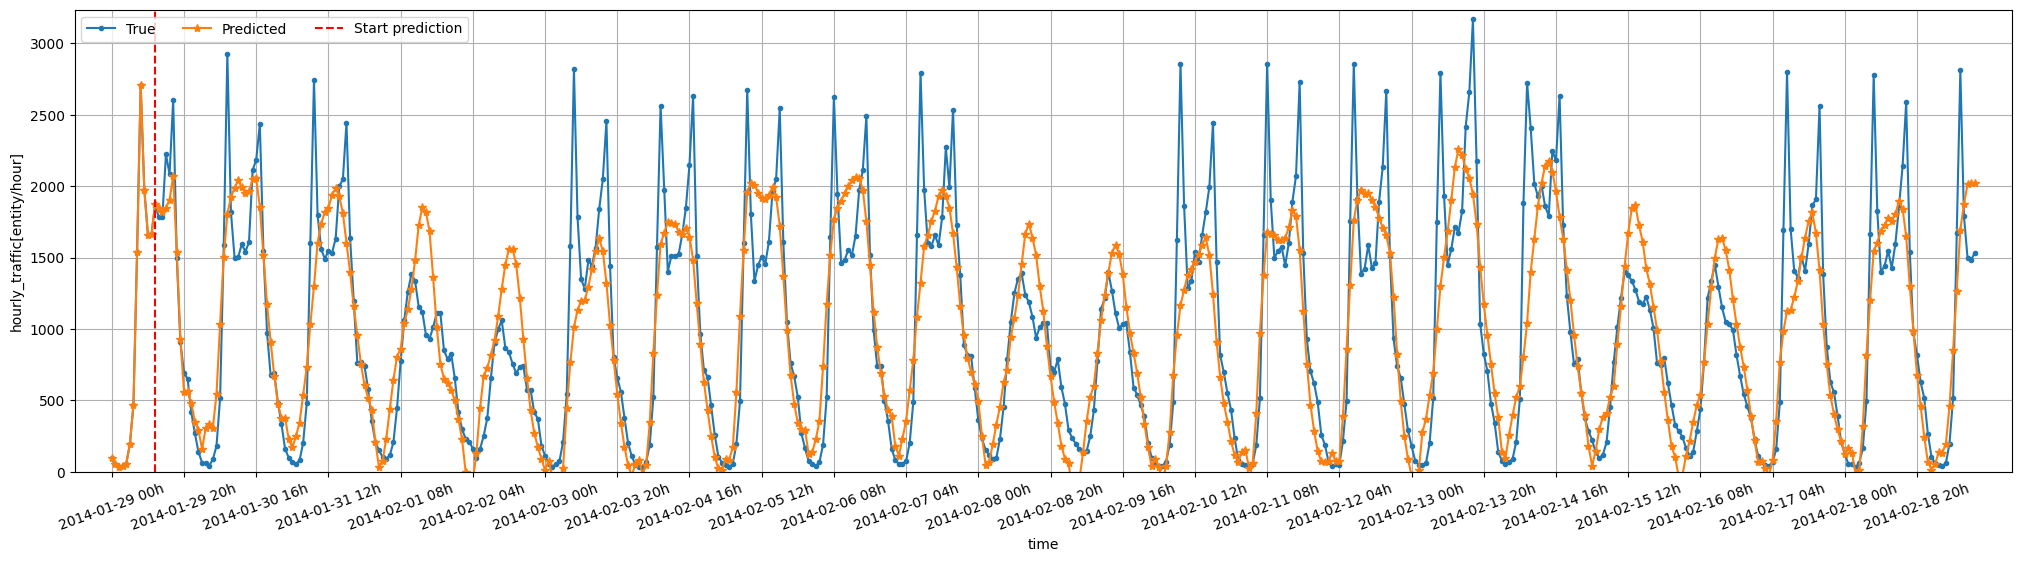

{'mean_squared_error': 0.049, 'mean_absolute_error': 0.1527}
{'mean_squared_error': 158912.66, 'mean_absolute_error': 274.9371}


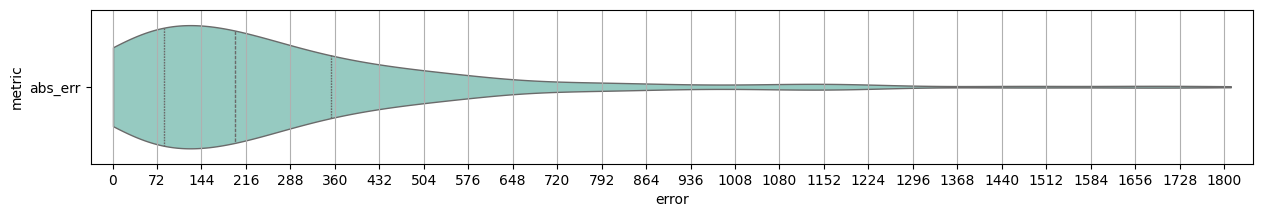

mean         std       min        25%         50%         75%  \
error  274.937083  288.942698  0.812325  84.010426  197.859239  352.998738   

               max  
error  1810.749588

---

cnn_1d:


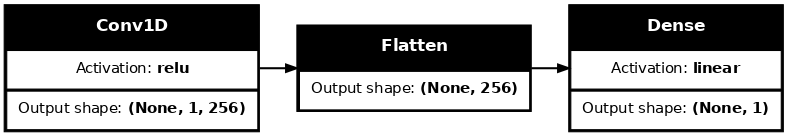

Free-Run: 100%|██████████| 504/504 [00:04<00:00, 111.86it/s]


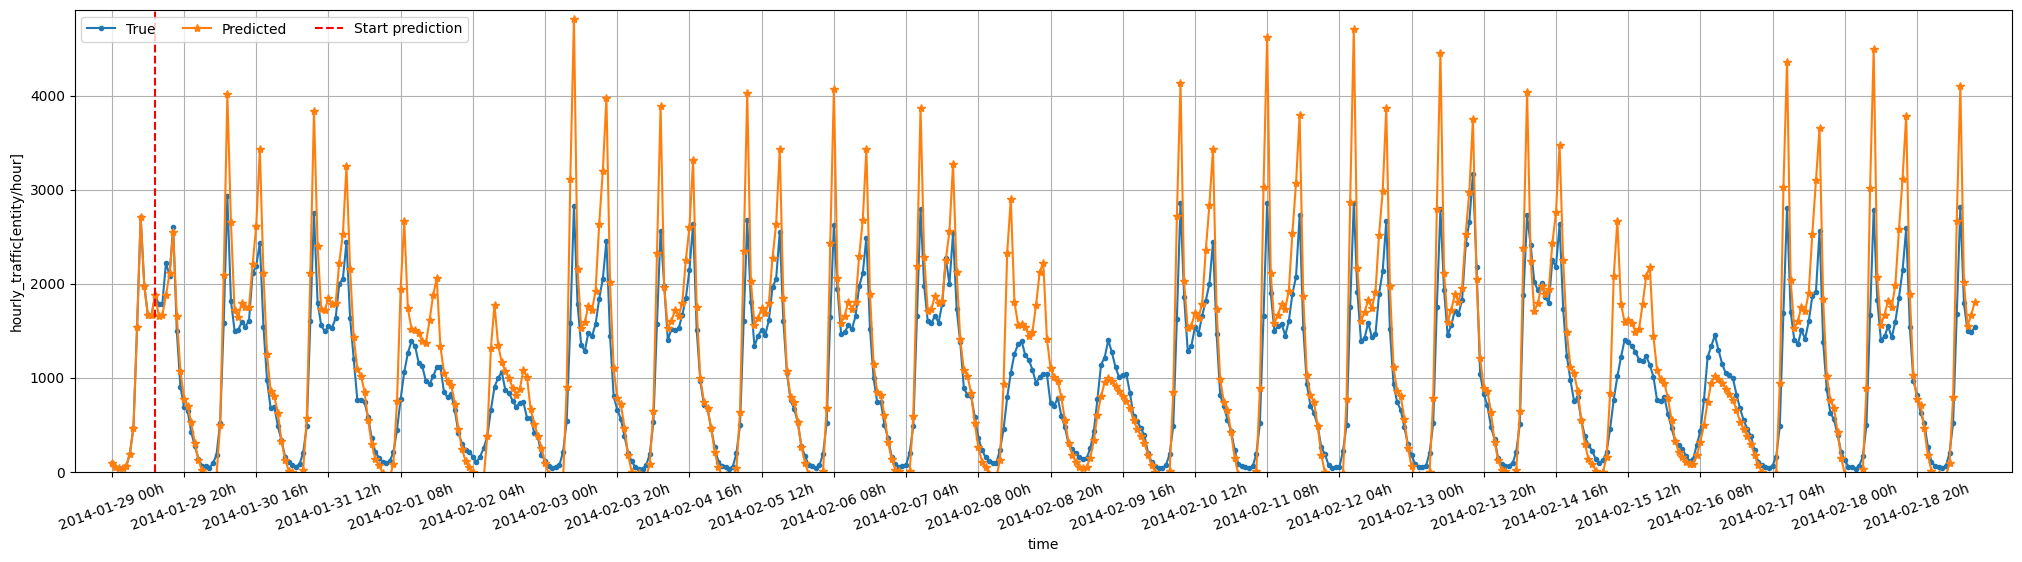

{'mean_squared_error': 0.07, 'mean_absolute_error': 0.1709}
{'mean_squared_error': 226853.42, 'mean_absolute_error': 307.6752}


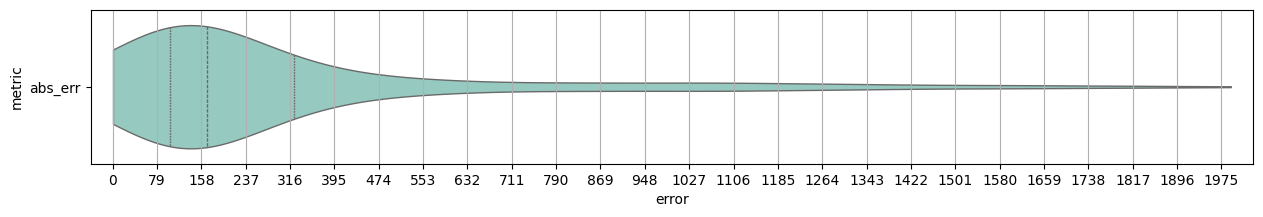

mean         std       min         25%         50%         75%  \
error  307.675157  363.939903  0.619366  102.865341  168.914077  323.818996   

               max  
error  1991.807297

---

LSTM_1_Layer:


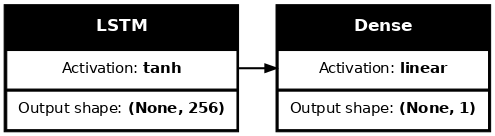

Free-Run: 100%|██████████| 504/504 [00:11<00:00, 42.73it/s]


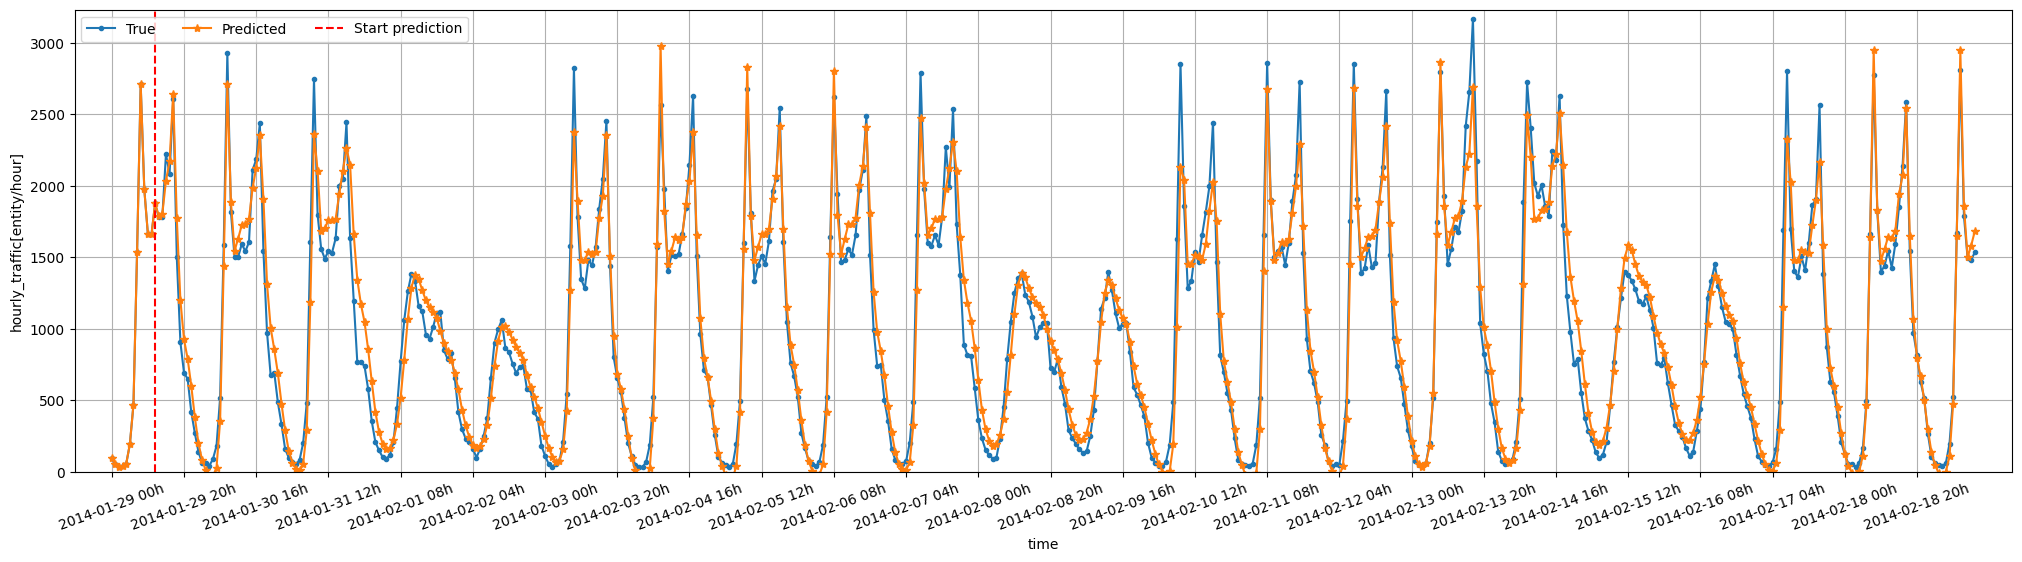

{'mean_squared_error': 0.0088, 'mean_absolute_error': 0.0711}
{'mean_squared_error': 28407.766, 'mean_absolute_error': 128.0252}


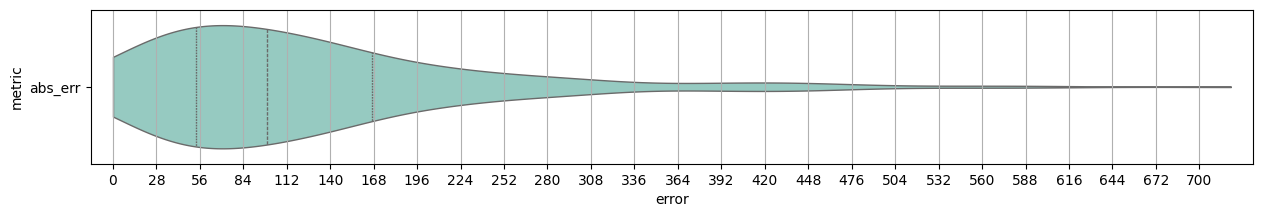

mean         std       min        25%       50%         75%  \
error  128.02516  109.732472  0.069092  53.517232  99.05279  166.707098   

              max  
error  720.267468

---

Return_Sequenze:


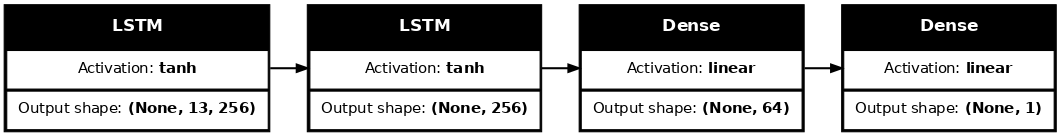

Free-Run: 100%|██████████| 504/504 [00:20<00:00, 25.08it/s]


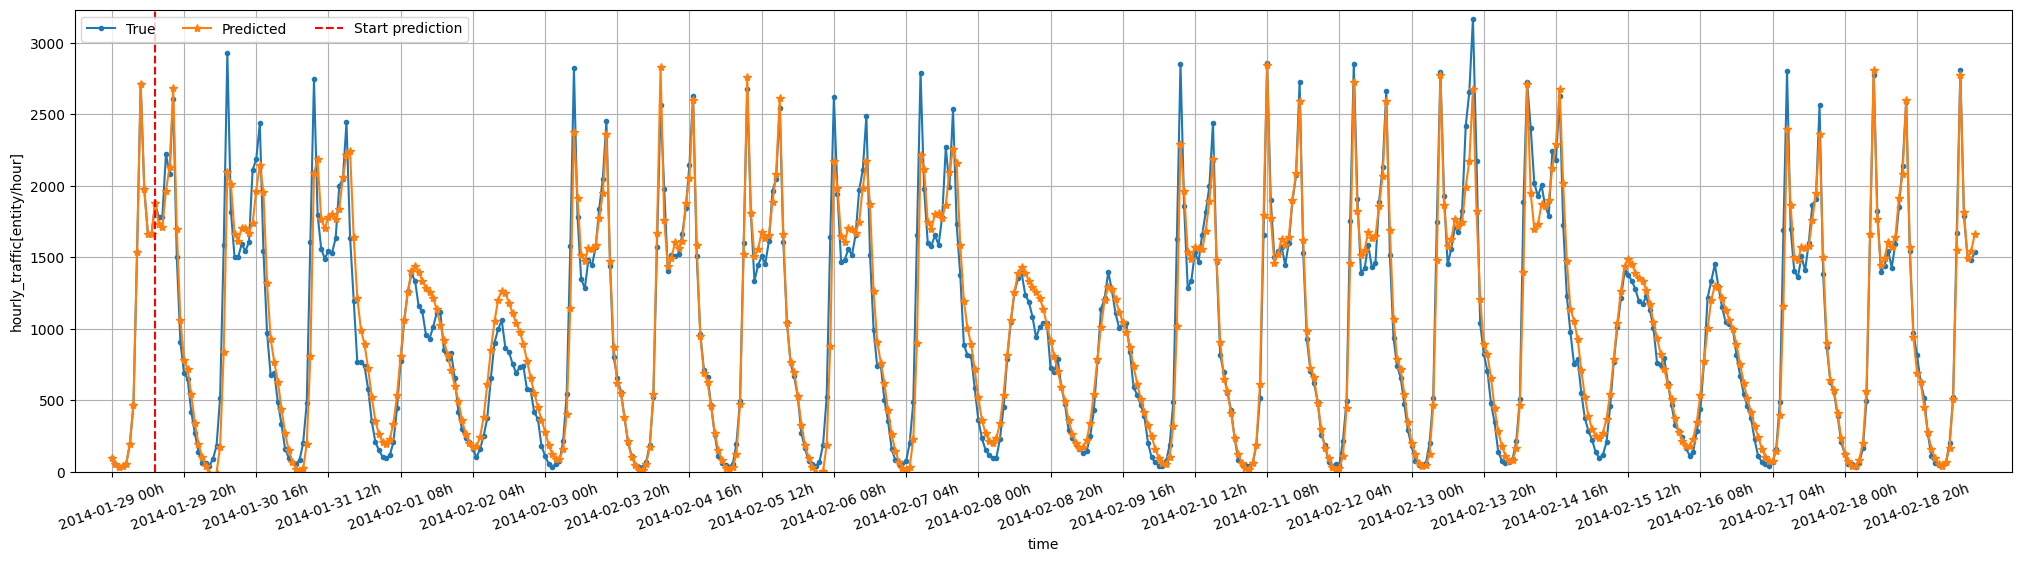

{'mean_squared_error': 0.0096, 'mean_absolute_error': 0.0659}
{'mean_squared_error': 31083.85, 'mean_absolute_error': 118.591}


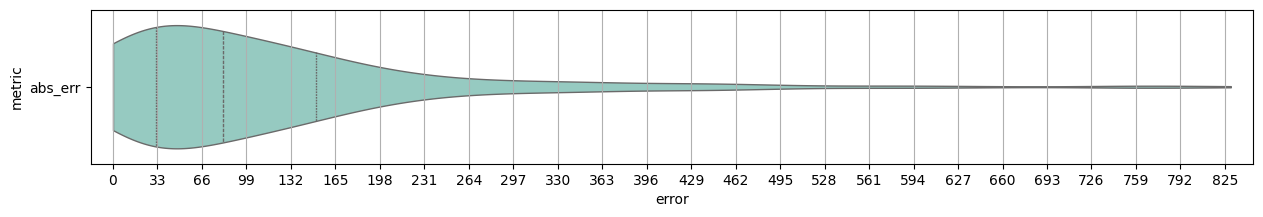

mean         std       min        25%        50%         75%  \
error  118.591019  130.590426  0.132786  31.992628  82.003802  150.445483   

              max  
error  829.354767

---

GRU_1_Layer:


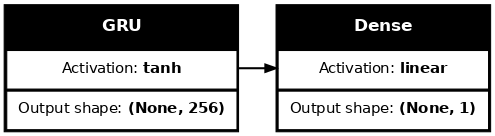

Free-Run: 100%|██████████| 504/504 [00:08<00:00, 57.32it/s]


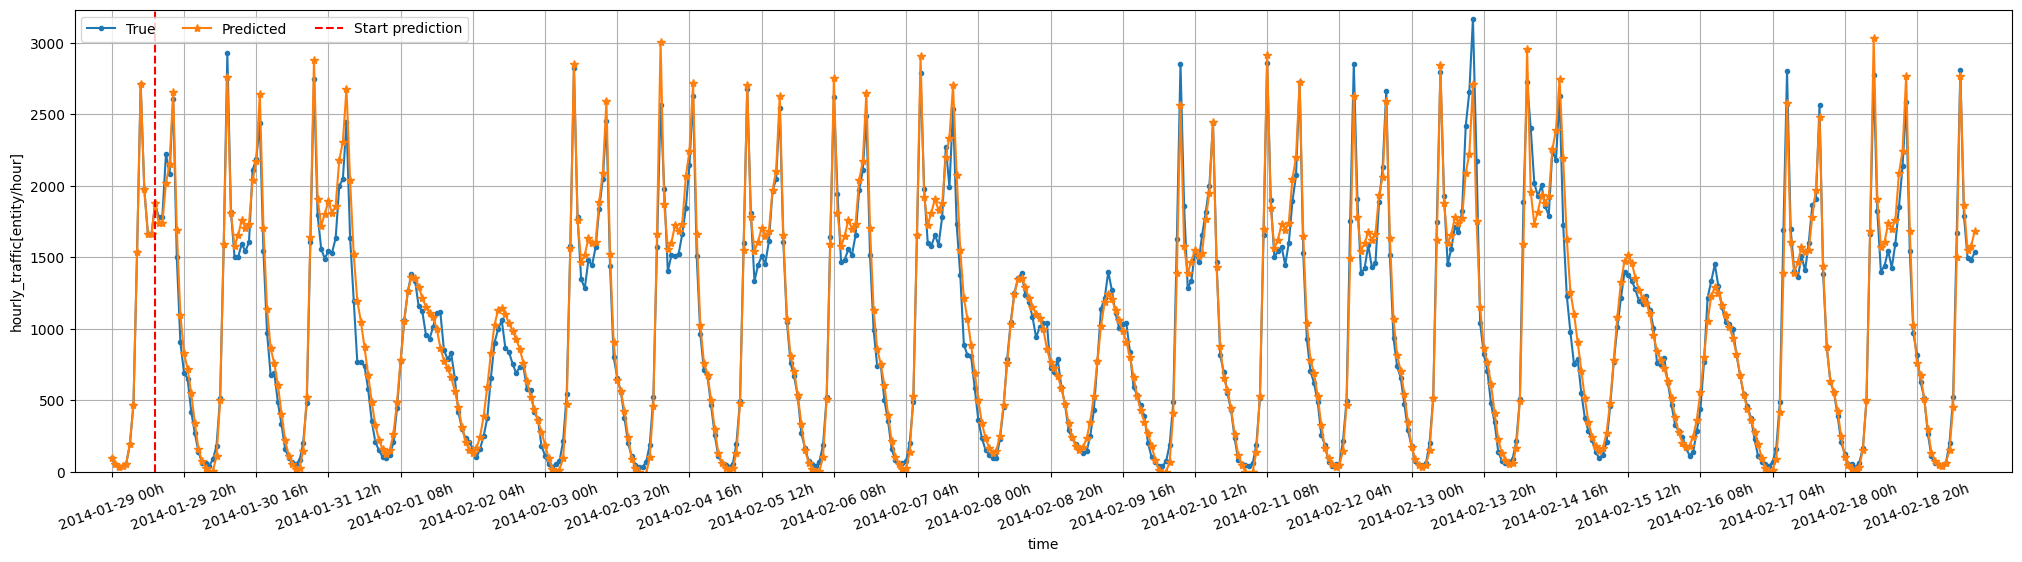

{'mean_squared_error': 0.005, 'mean_absolute_error': 0.0513}
{'mean_squared_error': 16182.104, 'mean_absolute_error': 92.4189}


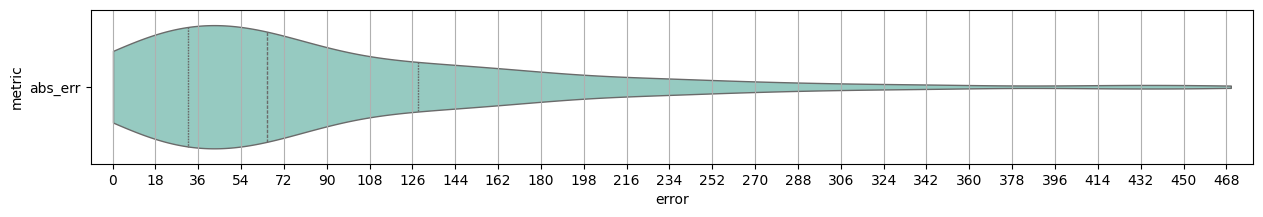

mean        std       min        25%        50%         75%  \
error  92.418943  87.498765  0.183119  31.829457  64.917187  128.485857   

              max  
error  469.863224

---

Bidirectional_LSTM:


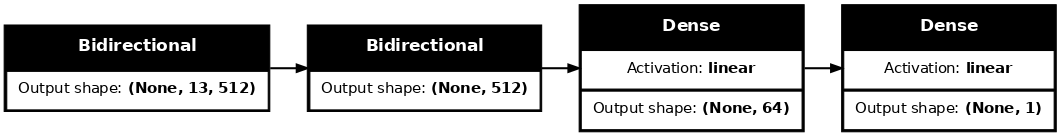

Free-Run: 100%|██████████| 504/504 [00:58<00:00,  8.62it/s]


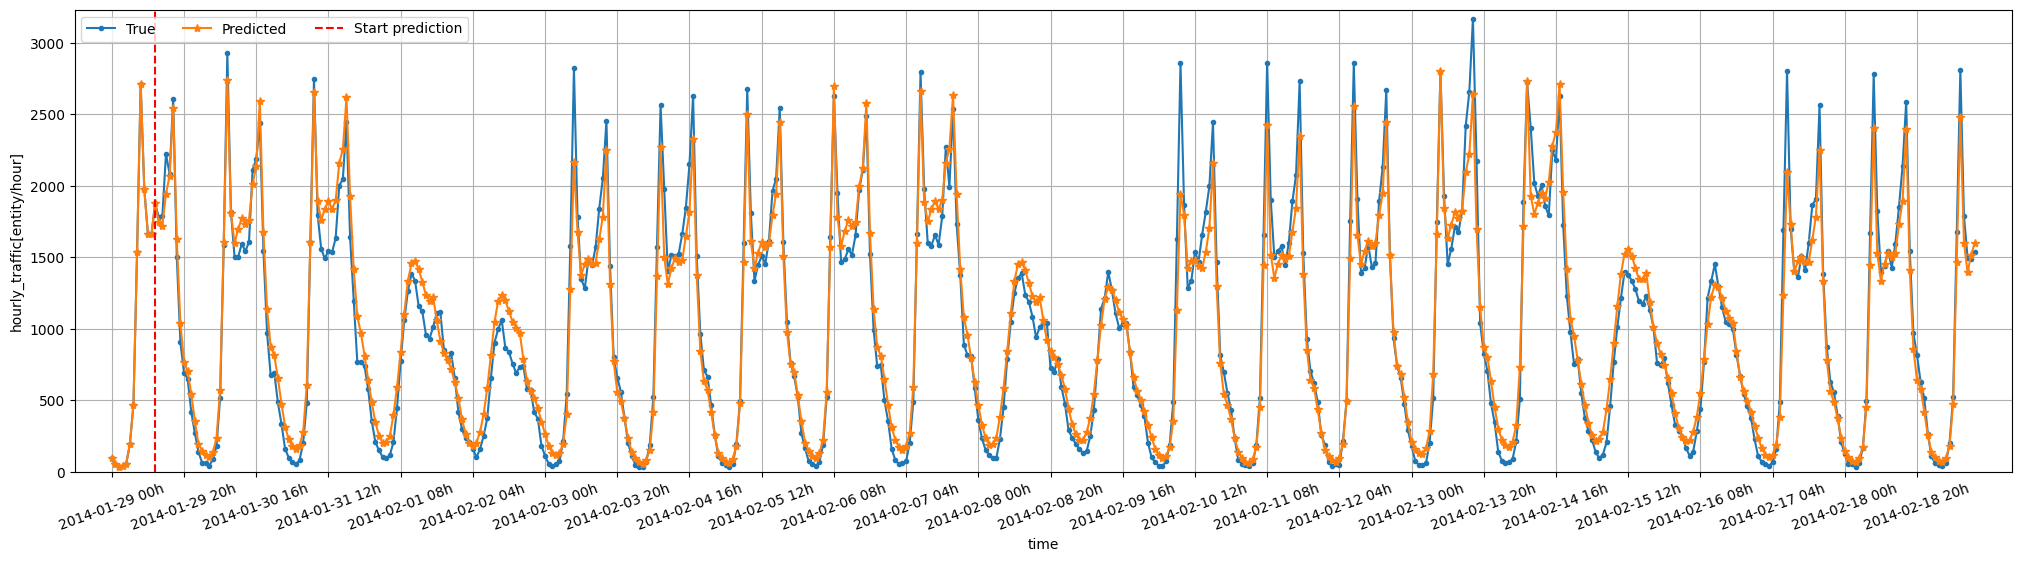

{'mean_squared_error': 0.0077, 'mean_absolute_error': 0.0655}
{'mean_squared_error': 24807.004, 'mean_absolute_error': 117.9028}


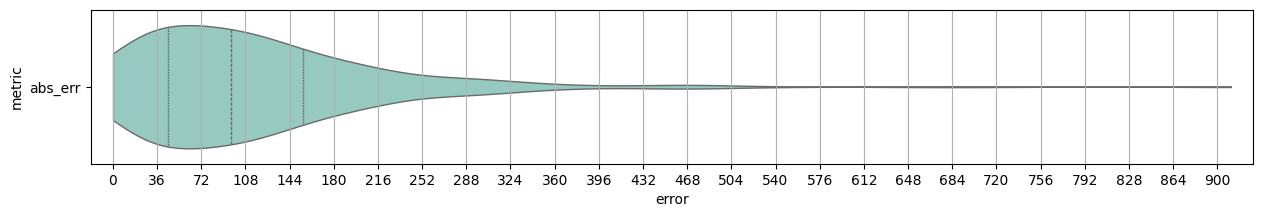

mean         std       min       25%        50%         75%  \
error  117.902842  104.535187  0.109135  45.20162  96.495707  154.690391   

              max  
error  910.955792

In [9]:
log = restore_model()

for key, model in log.items():
    display(Markdown("---"))
    print(f"\033[01m{key}\033[0m:")
    display(
        tf.keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=False,
            rankdir="LR",
            dpi=75,
            show_layer_activations=True,
        )
    )
    _ = imputer_same_site.predict_and_free_run(
        model, compute_on, save_name=f"site_{Base_Site}_predict_plus_"
    )
    # imputer_same_site.run_free_and_compute_metrics_within_range(model,compute_on, save_name=f"site_{Base_Site}_before_and_after_")
del log

#### Clear of the vars

In [10]:
del imputer_same_site, gen_cut_same_site

### On another site
The idea is to do the same thing as before and see if you can interpolate on that site

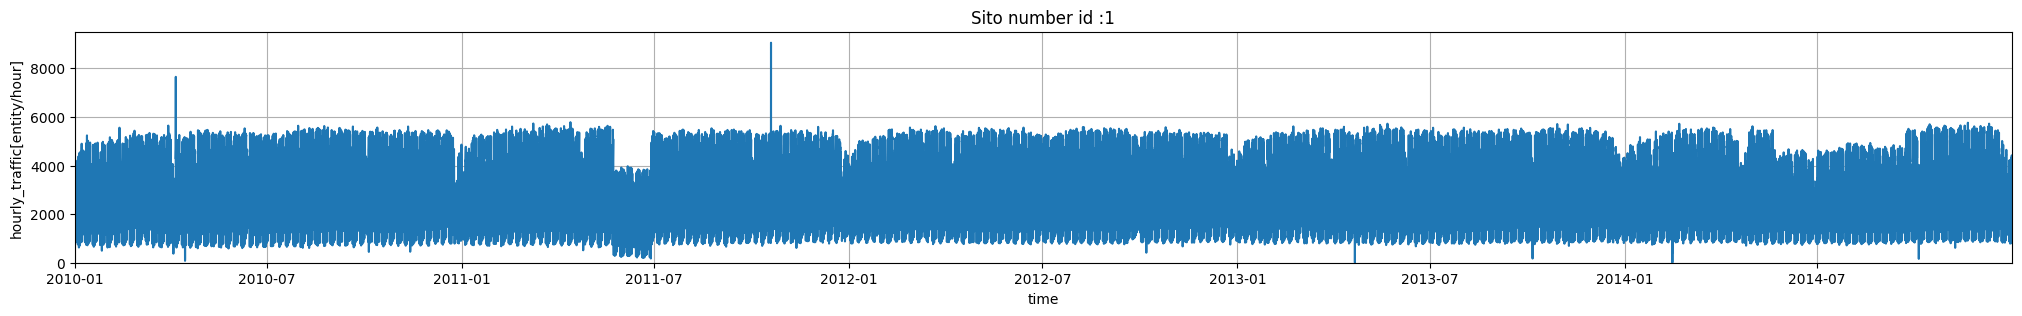

mean       std       min       25%       50%  \
hourly_traffic        1.736543  0.794757  0.003333  0.986667  1.826389   
temperature_2m        0.833086  0.301616  0.117000  0.612000  0.774500   
apparent_temperature  0.721823  0.344139 -0.049737  0.465404  0.656857   
relative_humidity_2m  0.657317  0.197985  0.081371  0.516910  0.679468   
precipitation         0.010049  0.049863  0.000000  0.000000  0.000000   
wind_speed_10m        1.068027  0.514500  0.000000  0.686417  1.012845   
cloud_cover           0.338667  0.311726  0.000000  0.030000  0.288000   

                           75%       max  
hourly_traffic        2.456667  5.028889  
temperature_2m        1.004500  2.019500  
apparent_temperature  0.925835  2.071331  
relative_humidity_2m  0.820077  1.000000  
precipitation         0.000000  1.560000  
wind_speed_10m        1.399428  3.755674  
cloud_cover           0.558000  1.000000

Site type: SIGNALISED_4_WAY_INTERSECTION


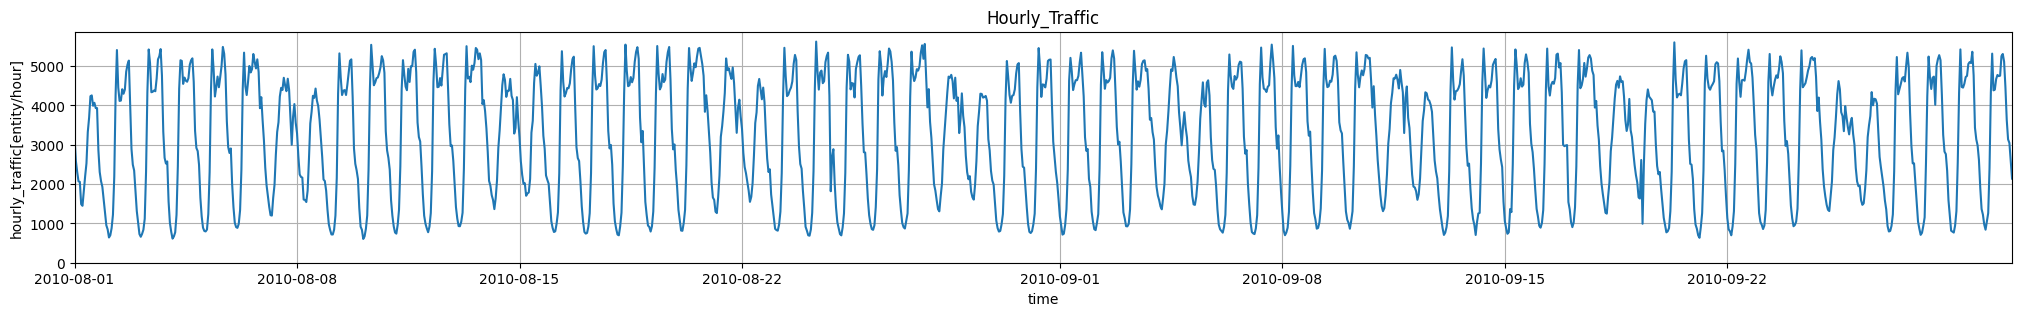

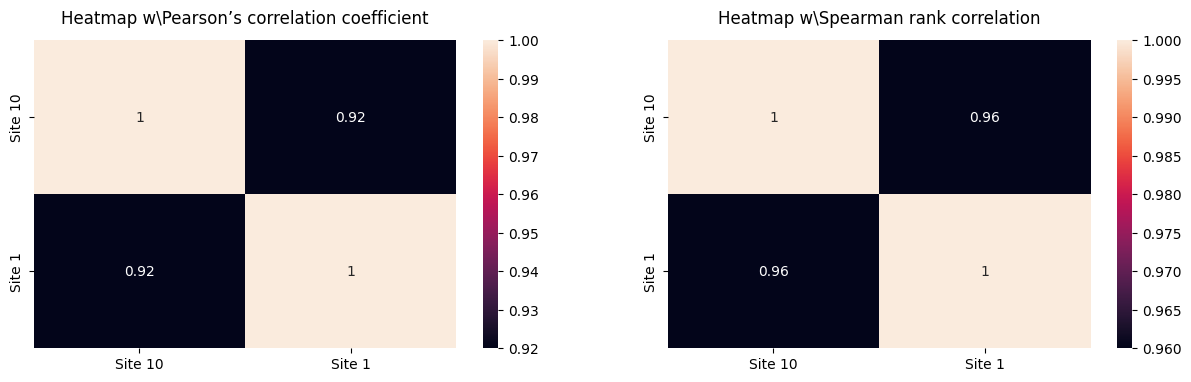

In [37]:
New_site = 1
imputer_on_another_site = Imputation(Test_Site, workspace)
imputer_on_another_site.select_site_and_full_range(
    data, New_site, range((week * 4 * 8) - (24 * 12), week * 4 * 10 - (24 * 7))
)

gen_cut_on_another_site = Test_Site.copy()
gen_cut_on_another_site.df = imputer_on_another_site.Gen.df[
    compute_on.start : compute_on.stop
].reset_index(drop=True)
gen_cut_on_another_site.n = len(gen_cut_on_another_site.df)
GeneralPlotter.compute_site_correlation(
    data.df, [Base_Site, New_site], "img/" + workspace + "/"
)

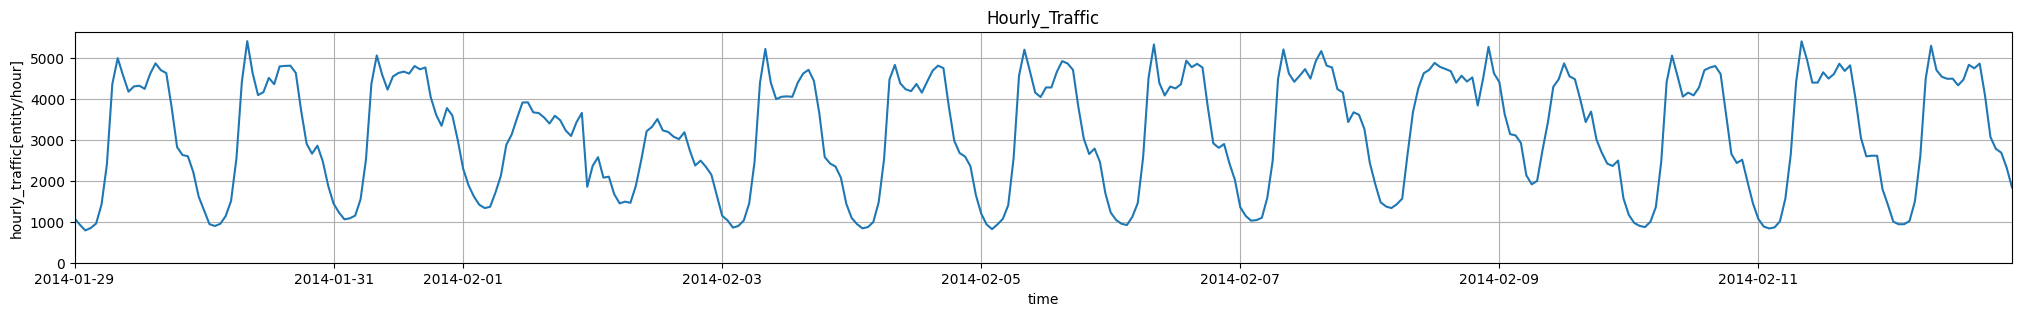

In [36]:
src = data.df.copy()
src = src[src.site_no == 1]

test_set = src[
    (src["date"] >= "2014-01-29 00:00:00") & (src["date"] < "2014-02-13 00:00:00")
].reset_index(drop=True)

gen_cut_on_another_site = Test_Site.copy()
gen_cut_on_another_site.change_df(test_set)
gen_cut_on_another_site.batch_size = 24

imputer_on_another_site = Imputation(gen_cut_on_another_site, workspace)
gen_cut_on_another_site.plot_df()

#### Interpolation starting from the point of interest

---

Lineare:


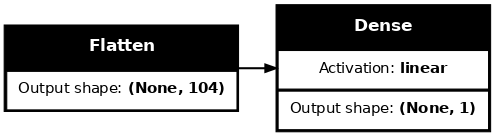

Free-Run: 100%|██████████| 347/347 [00:02<00:00, 144.18it/s]


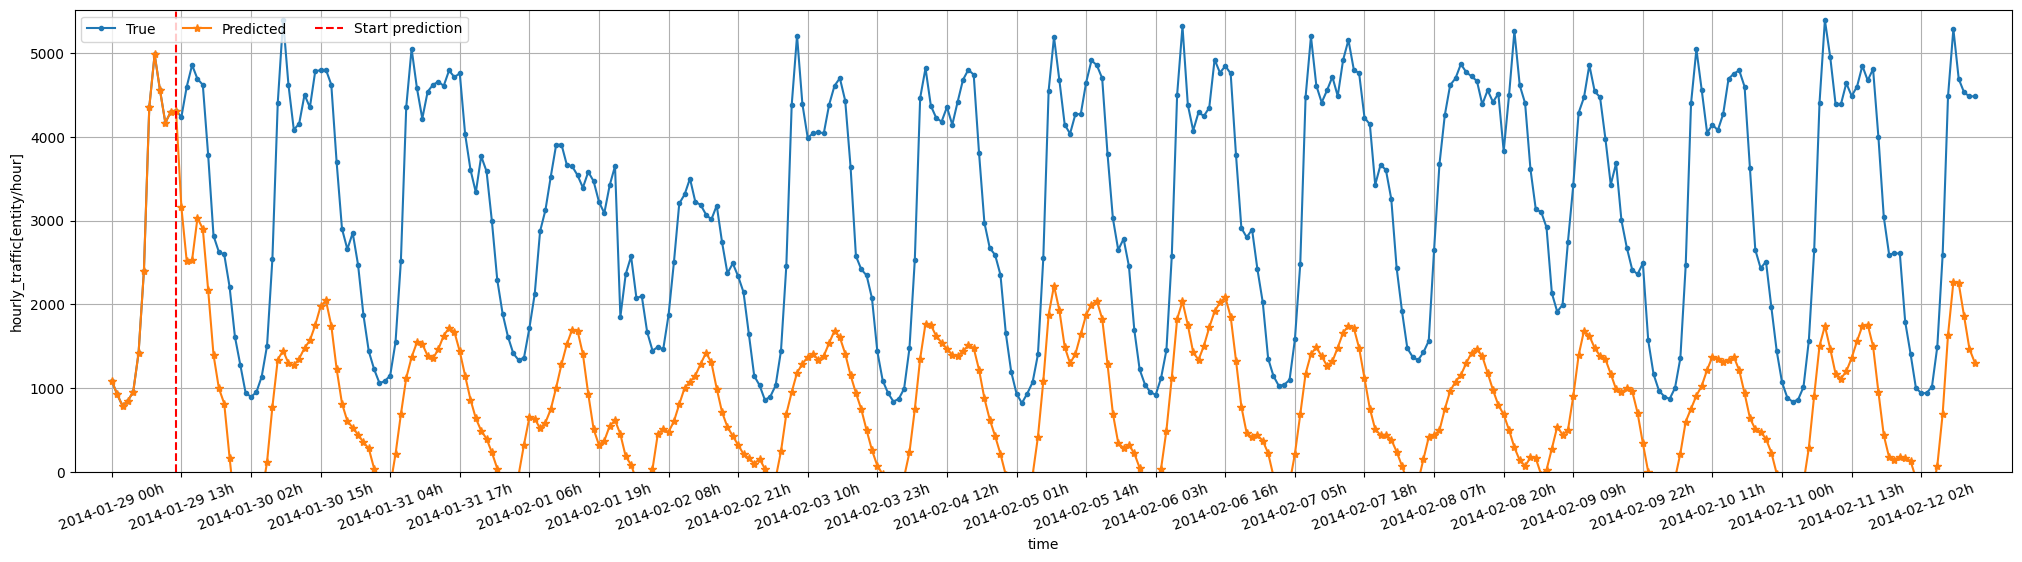

mean_squared_error: 1.9060(1.3806) - mean_absolute_error: 1.3026
DeNorm_mean_squared_error: 6175346.5000(2485.0244) - DeNorm_mean_absolute_error: 2344.6753


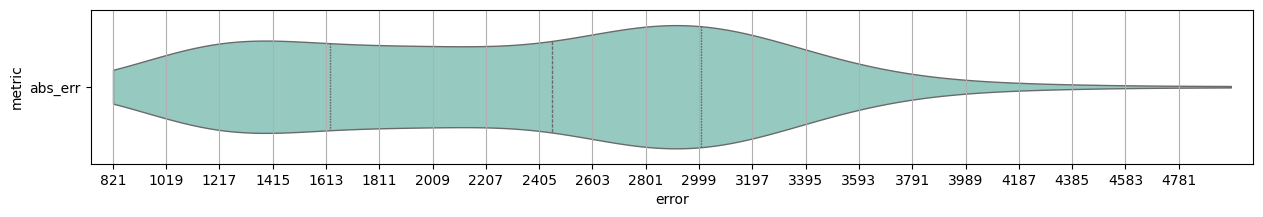

mean         std         min          25%          50%  \
error  2344.675415  824.501656  821.842464  1626.641894  2454.472333   

               75%          max  
error  3007.605363  4974.422465

---

Conv1D:


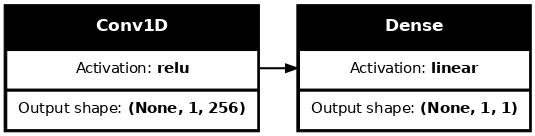

Free-Run: 100%|██████████| 347/347 [00:03<00:00, 97.77it/s] 


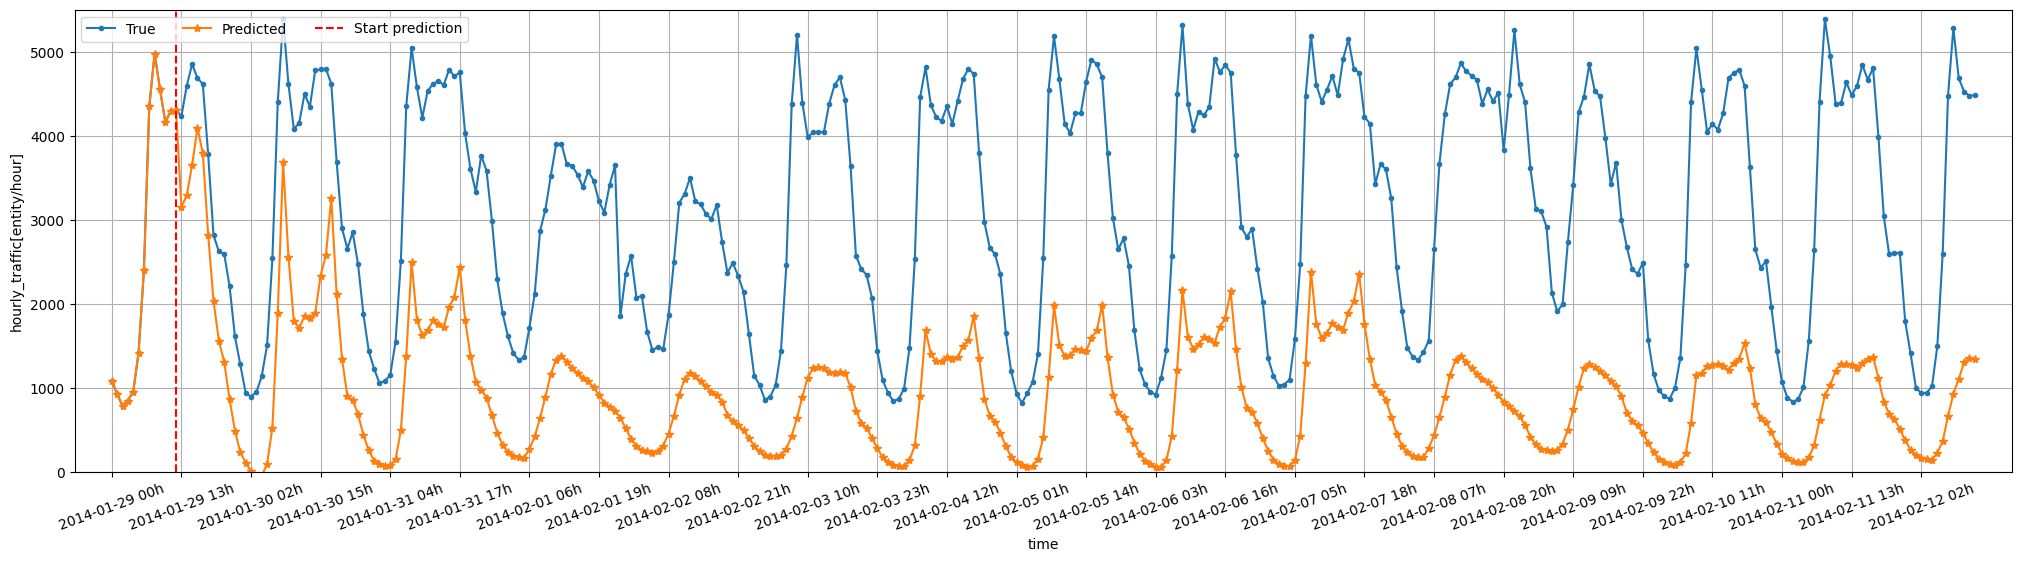

mean_squared_error: 1.7835(1.3355) - mean_absolute_error: 1.2354
DeNorm_mean_squared_error: 5778649.0000(2403.8821) - DeNorm_mean_absolute_error: 2223.7439


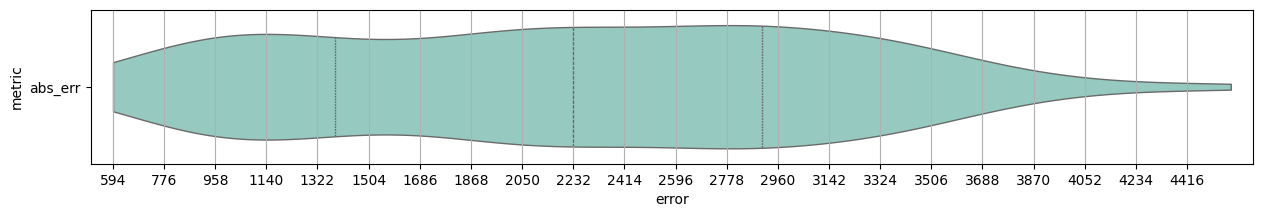

mean         std         min          25%          50%  \
error  2223.74395  914.341974  594.721598  1385.535239  2231.750334   

               75%          max  
error  2904.351207  4571.335797

---

GRU:


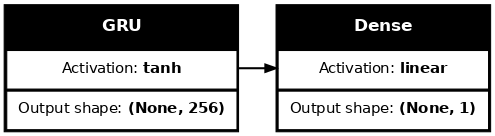

Free-Run: 100%|██████████| 347/347 [00:05<00:00, 60.10it/s]


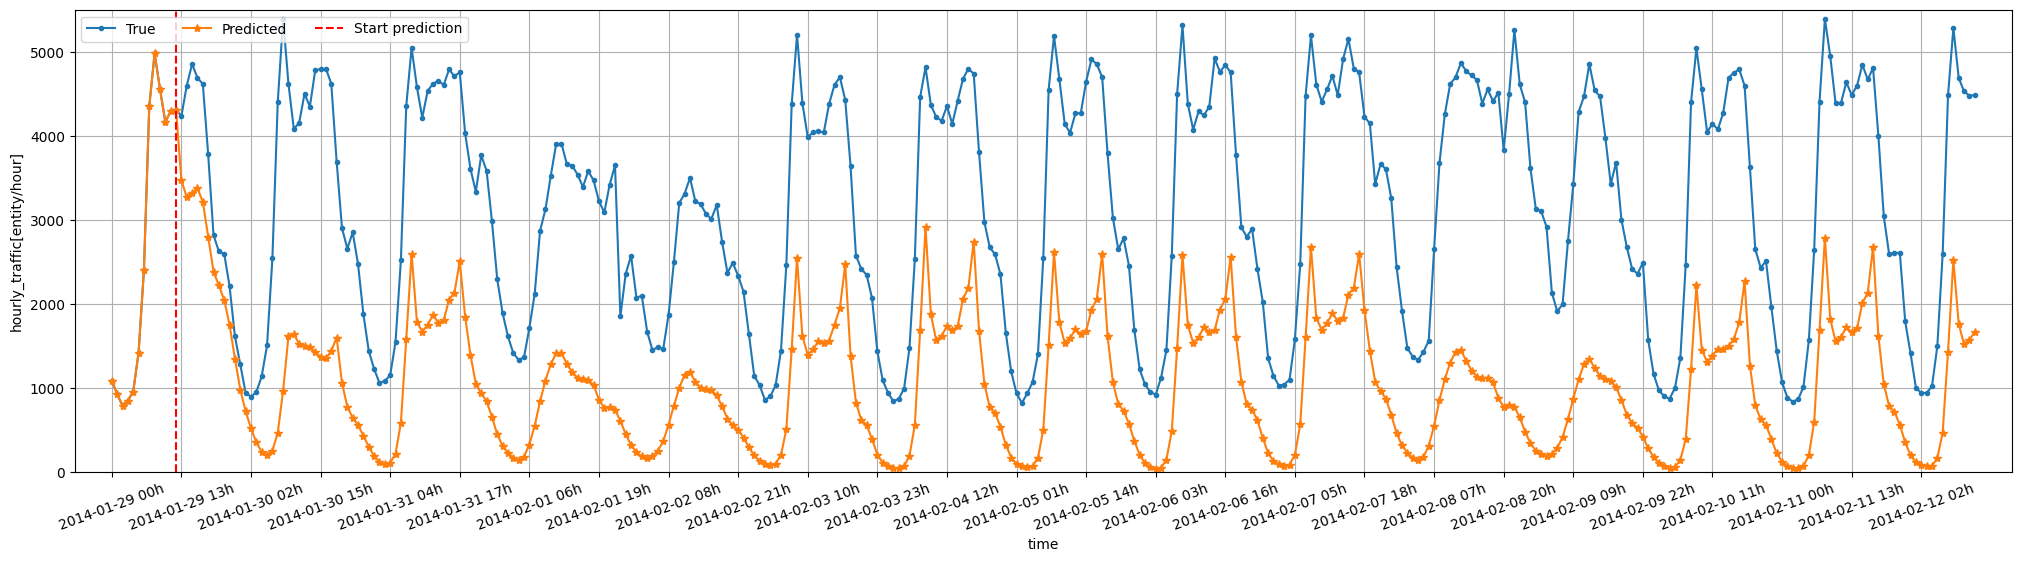

mean_squared_error: 1.5852(1.2590) - mean_absolute_error: 1.1728
DeNorm_mean_squared_error: 5136028.5000(2266.2808) - DeNorm_mean_absolute_error: 2110.9556


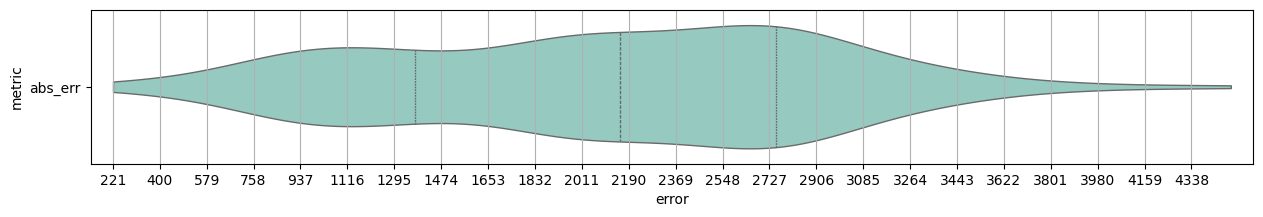

mean         std         min          25%          50%  \
error  2110.955407  825.748555  221.525917  1373.639499  2157.207168   

              75%          max  
error  2751.35692  4488.067885

---

un_layer_LSTM:


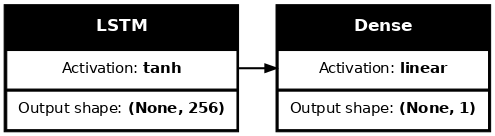

Free-Run: 100%|██████████| 347/347 [00:06<00:00, 57.13it/s]


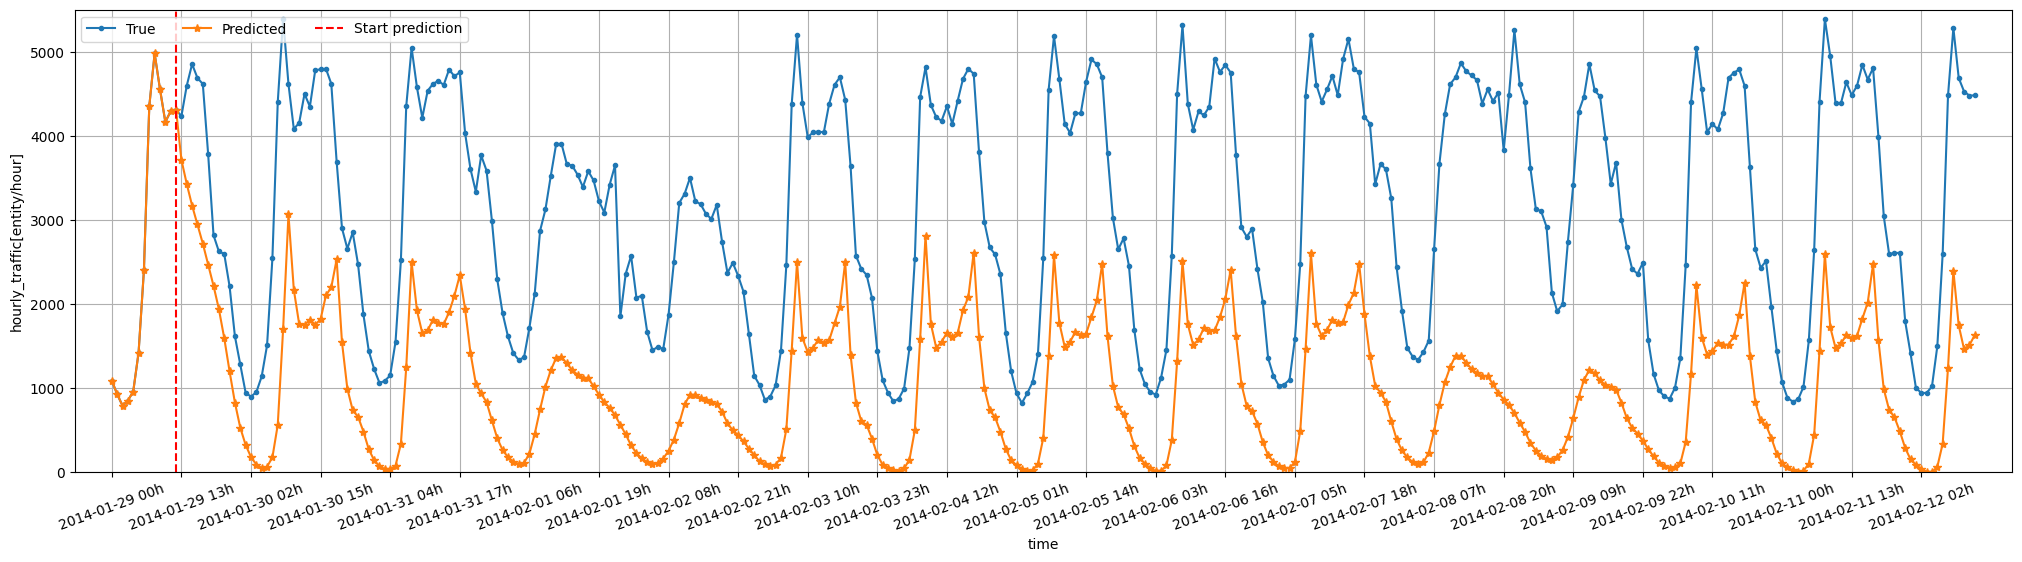

mean_squared_error: 1.6222(1.2737) - mean_absolute_error: 1.1946
DeNorm_mean_squared_error: 5255967.0000(2292.5896) - DeNorm_mean_absolute_error: 2150.1912


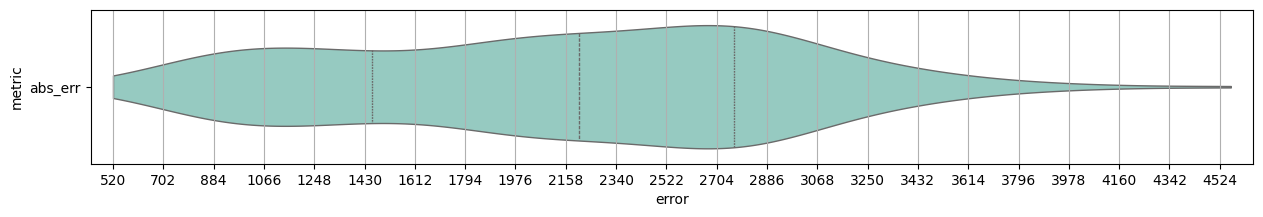

mean         std         min          25%          50%  \
error  2150.191177  796.538404  520.126642  1457.004312  2204.176883   

               75%          max  
error  2767.756473  4563.979174

---

Stacked_LSTM:


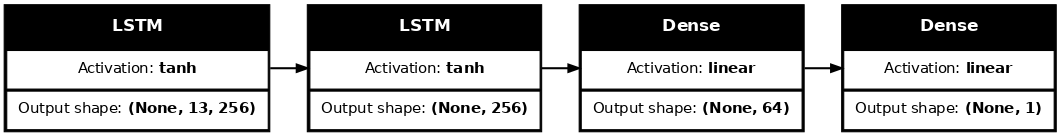

Free-Run: 100%|██████████| 347/347 [00:14<00:00, 23.89it/s]


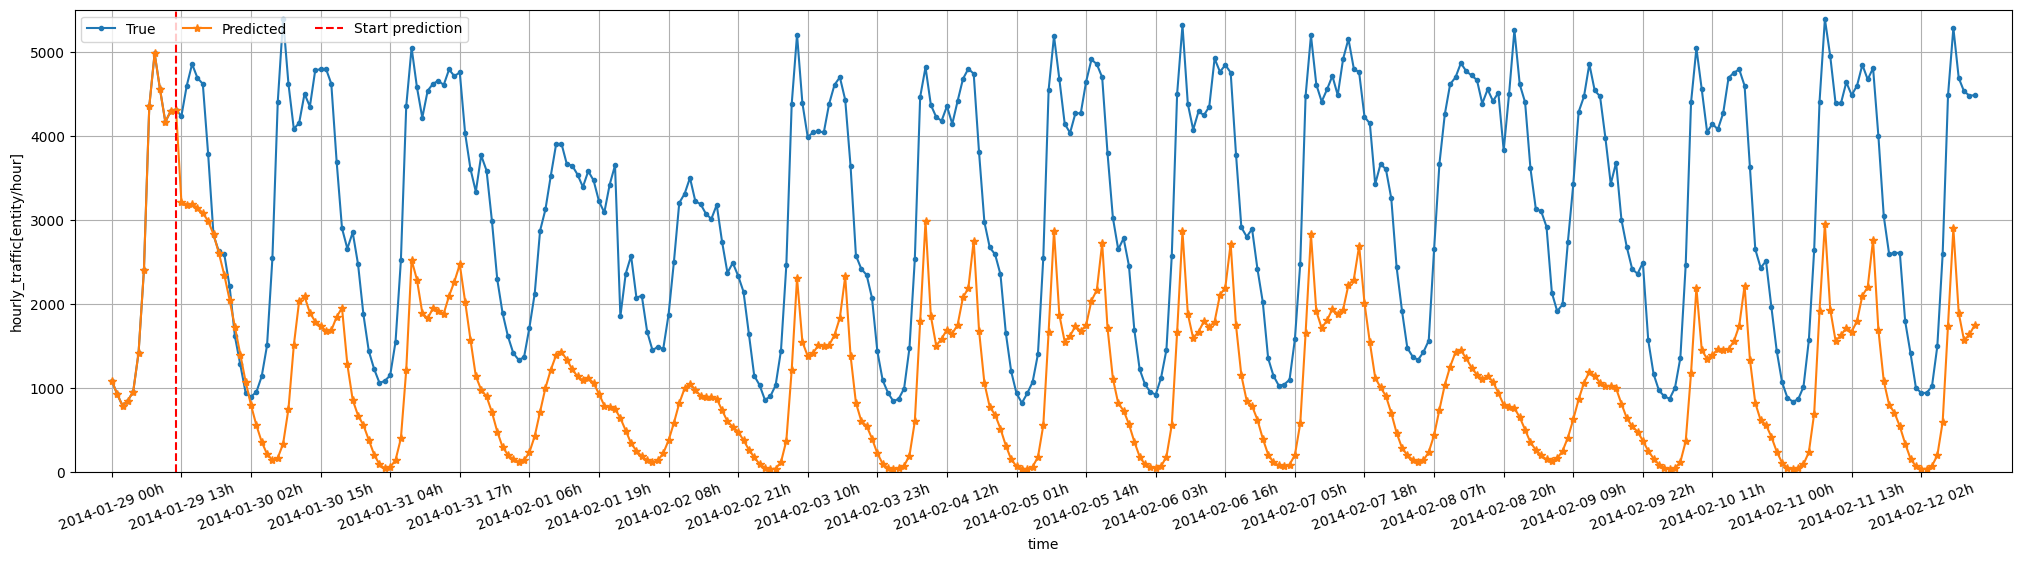

mean_squared_error: 1.5652(1.2511) - mean_absolute_error: 1.1621
DeNorm_mean_squared_error: 5071102.5000(2251.9109) - DeNorm_mean_absolute_error: 2091.8364


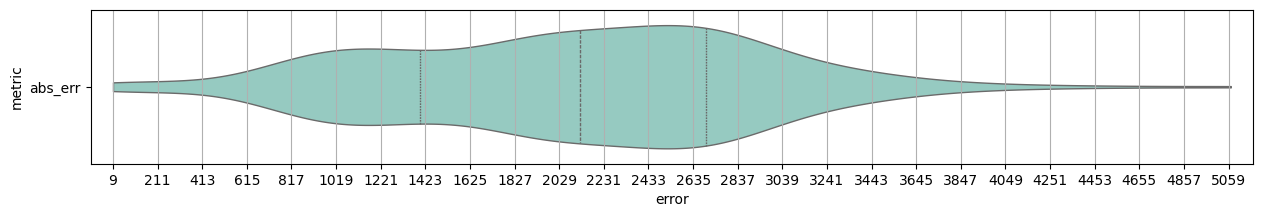

mean         std       min          25%          50%  \
error  2091.836375  835.064573  9.022622  1396.432687  2123.251423   

               75%          max  
error  2693.622252  5068.959154

In [14]:
# log = restore_model()
log = restore_model()
for key, model in log.items():
    display(Markdown("---"))
    print(f"\033[01m{key}\033[0m:")
    display(
        tf.keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=False,
            rankdir="LR",
            dpi=75,
            show_layer_activations=True,
        )
    )
    path = f"img/{workspace}/{model.name}/"
    os.makedirs(path, exist_ok=True)
    pred, _, _ = Trainer.free_run_with_plots(
        model,
        gen_cut_on_another_site,
        -1,
        range_plot,
        folder=path + f"site_{New_site}_start_on_hole",
    )
del log

#### Simple Prediction and then Free Run

---

Linear:


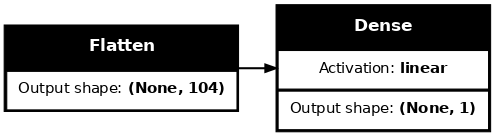

Predicting: 100%|██████████| 347/347 [00:03<00:00, 97.66it/s] 
Free-Run: 0it [00:00, ?it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
log = restore_model()

for key, model in log.items():
    display(Markdown("---"))
    print(f"\033[01m{key}\033[0m:")
    display(
        tf.keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=False,
            rankdir="LR",
            dpi=75,
            show_layer_activations=True,
        )
    )
    _ = imputer_on_another_site.predict_and_free_run(
        model, compute_on, save_name=f"site_{New_site}_predict_plus_"
    )
    #   imputer_same_site.run_free_and_compute_metrics_within_range(model,compute_on, save_name=f"site_{Base_Site}_before_and_after_")
del log

#### Clean variables

In [16]:
del imputer_on_another_site, gen_cut_on_another_site

#### Training on a random month and then free run
The idea is to do the same thing as before, but training the models on a small time frame

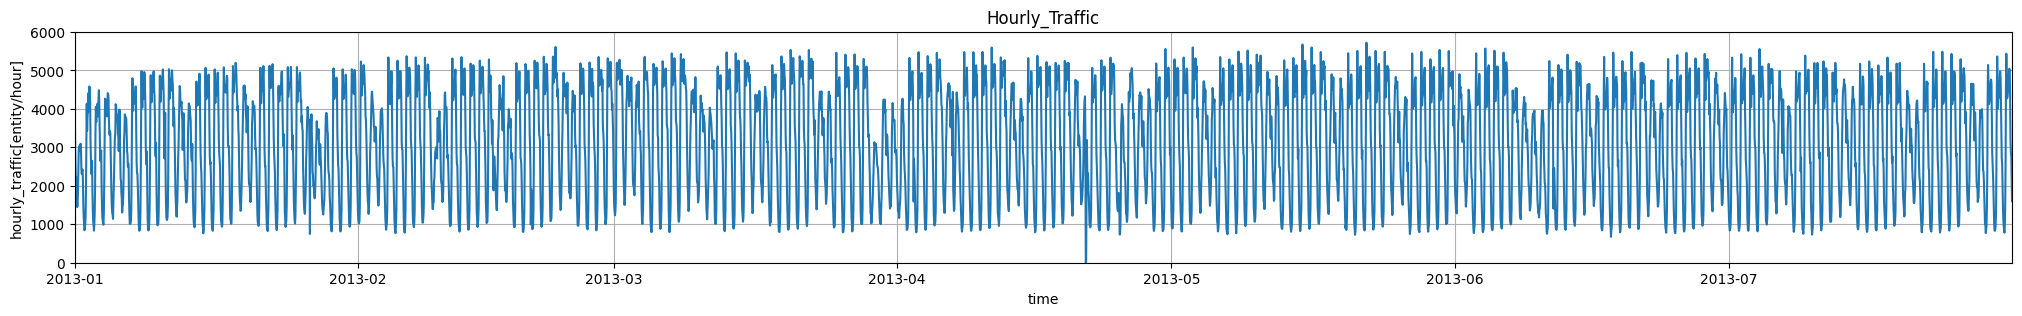

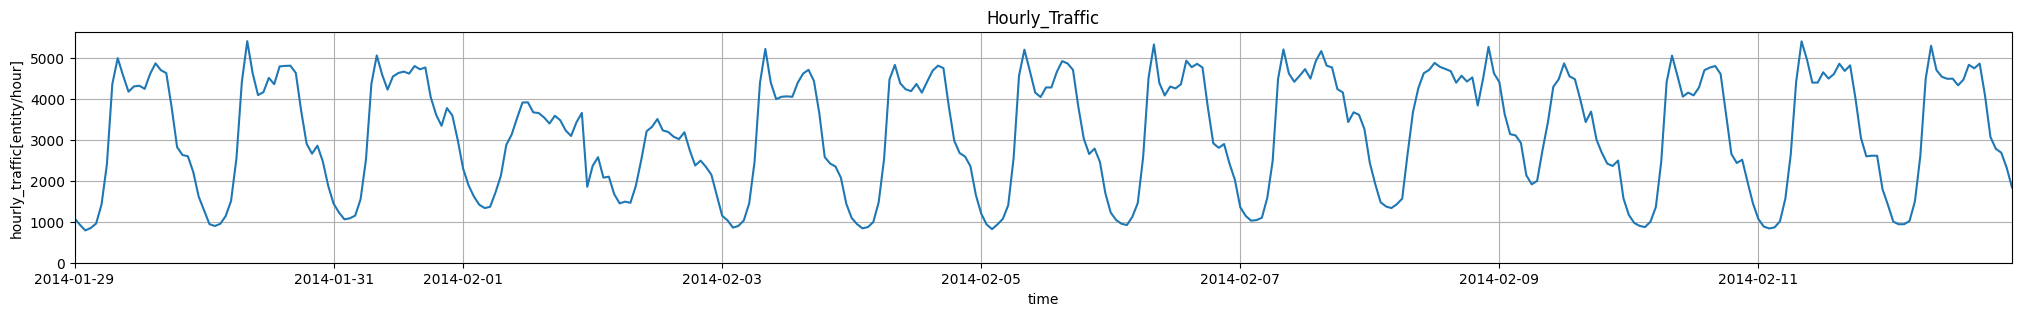

In [38]:
src = data.df.copy()
src = src[src.site_no == New_site]
training_set = (
    src[(src["date"] >= "2013-01-01 00:00:00") & (src["date"] < "2013-08-01 00:00:00")]
    .copy()
    .reset_index(drop=True)
)
test_set = src[
    (src["date"] >= "2014-01-29 00:00:00") & (src["date"] < "2014-02-13 00:00:00") # BUCO
].reset_index(drop=True)

Gen_training_on_another_site_t = Test_Site.copy()
Gen_training_on_another_site_t.change_df(training_set)
Gen_training_on_another_site_t.batch_size = 32

Gen_test_on_another_site_t = Test_Site.copy()
Gen_test_on_another_site_t.change_df(test_set)
Gen_test_on_another_site_t.batch_size = 24

imputer_on_another_site = Imputation(Gen_test_on_another_site_t, workspace)
Gen_training_on_another_site_t.plot_df()
Gen_test_on_another_site_t.plot_df()
# -- -- -- -- -- -- -- -- --
epoch = 2
del src

##### Training of Dense only

---

GRU:


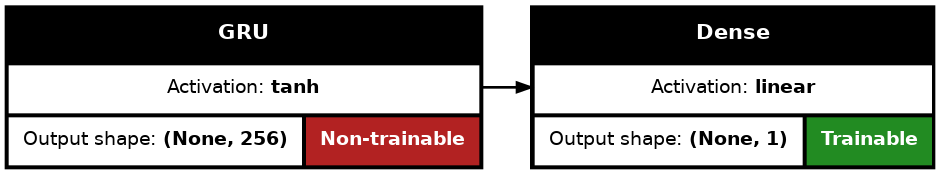

Free-Run: 100%|██████████| 347/347 [00:15<00:00, 21.73it/s]


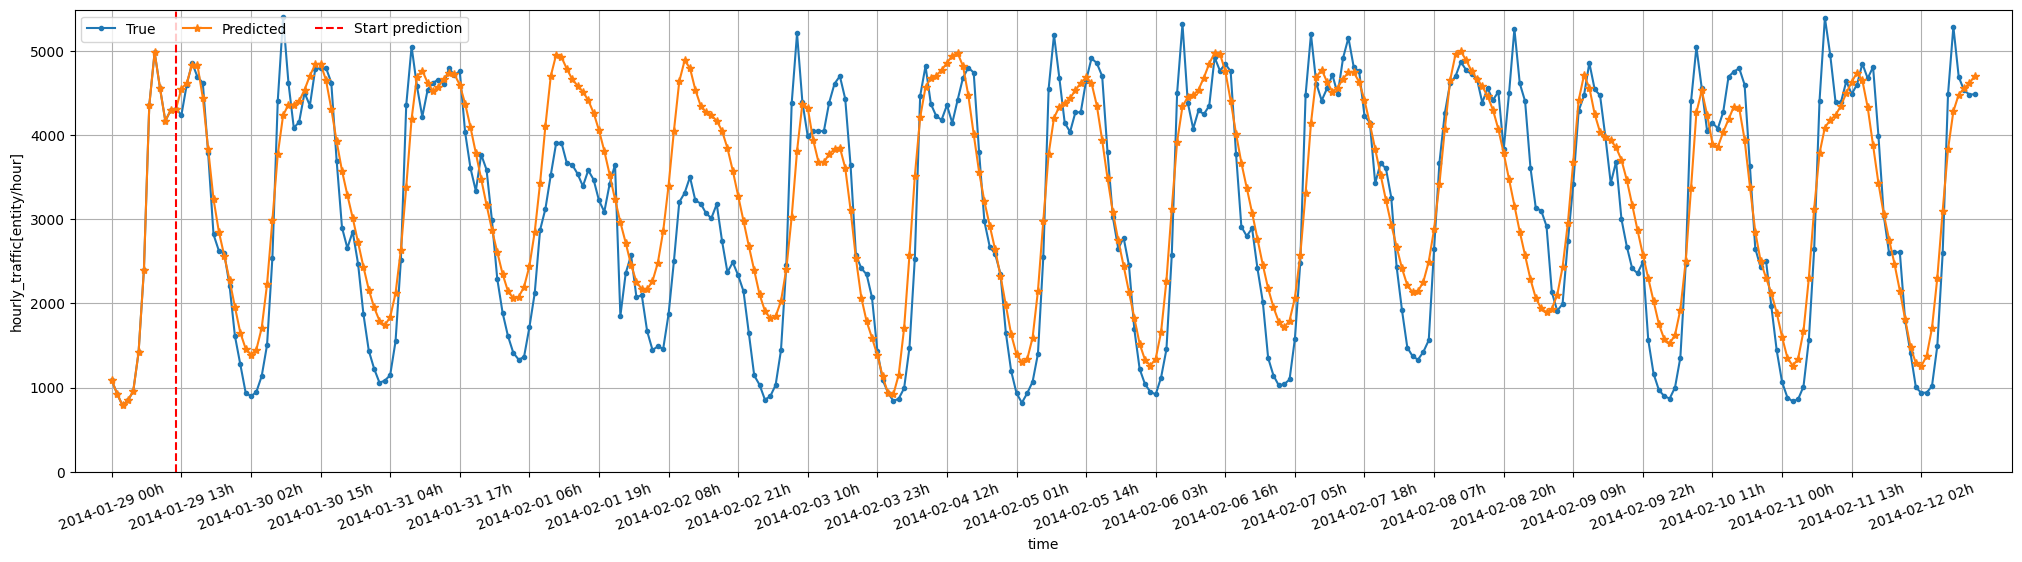

mean_squared_error: 0.1213(0.3483) - mean_absolute_error: 0.2743
DeNorm_mean_squared_error: 393074.0625(626.9562) - DeNorm_mean_absolute_error: 493.7508


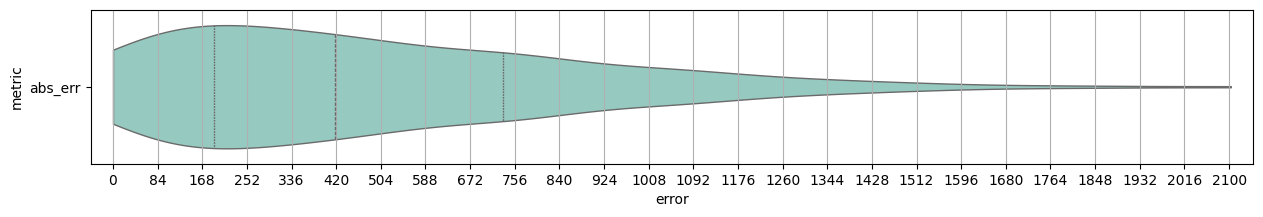

mean         std       min         25%       50%         75%  \
error  493.750818  386.931076  0.169821  189.578866  418.3741  733.522698   

               max  
error  2103.263225

---

un_layer_LSTM:


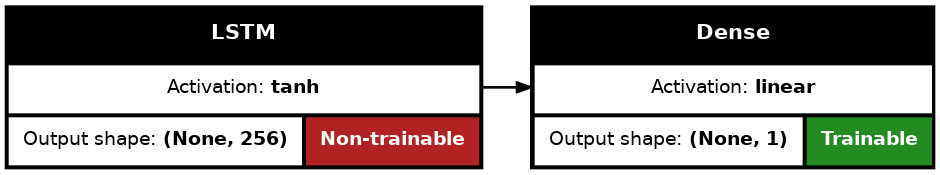

Free-Run: 100%|██████████| 347/347 [00:11<00:00, 29.14it/s]


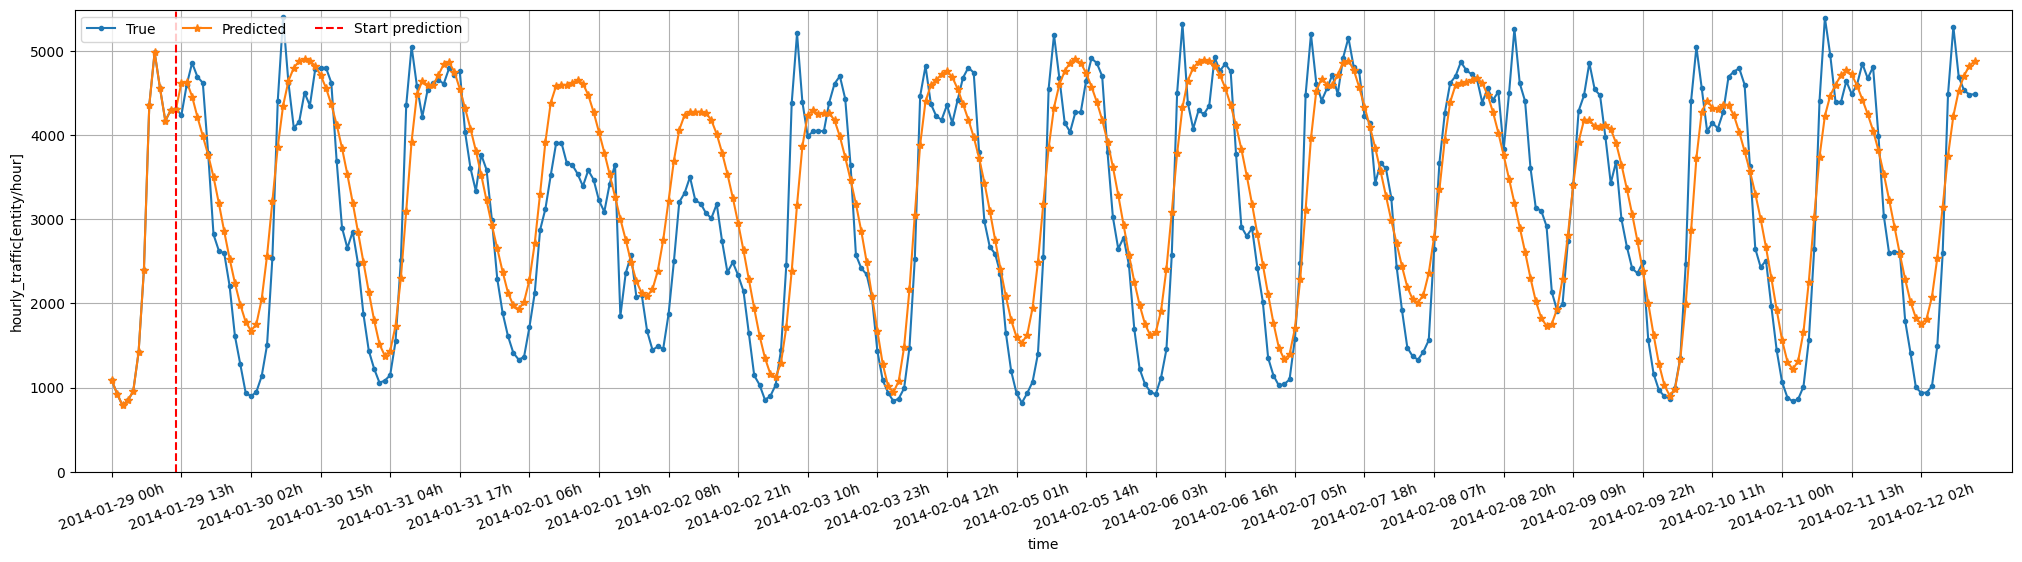

mean_squared_error: 0.1226(0.3501) - mean_absolute_error: 0.2843
DeNorm_mean_squared_error: 397122.2188(630.1763) - DeNorm_mean_absolute_error: 511.7386


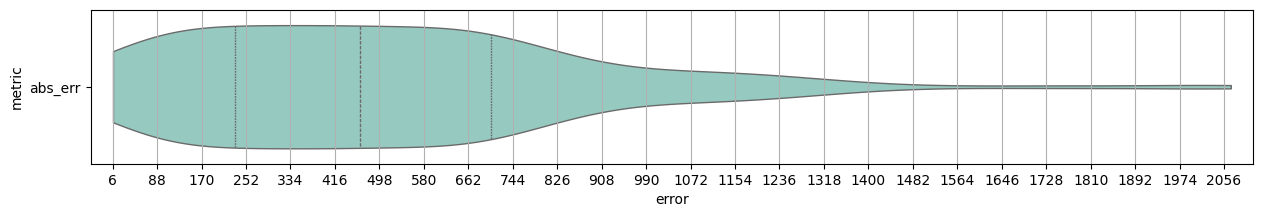

mean         std       min         25%         50%         75%  \
error  511.738619  368.288818  6.772594  232.299601  462.117346  704.644508   

               max  
error  2068.426694

---

Stacked_LSTM:


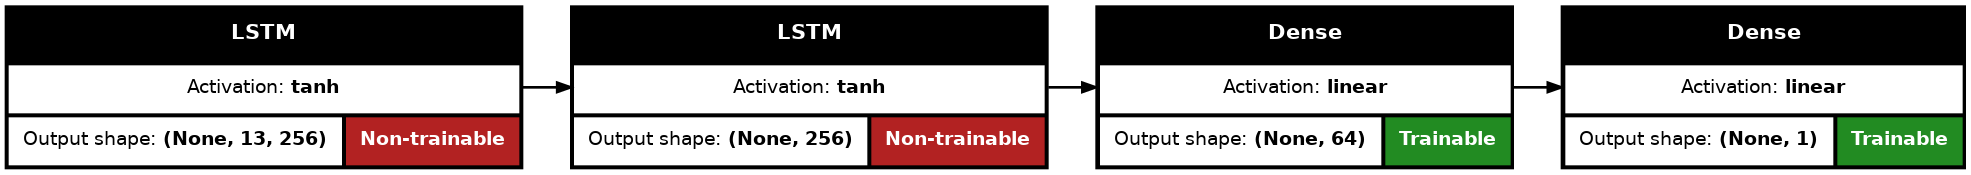

Free-Run: 100%|██████████| 347/347 [00:22<00:00, 15.53it/s]


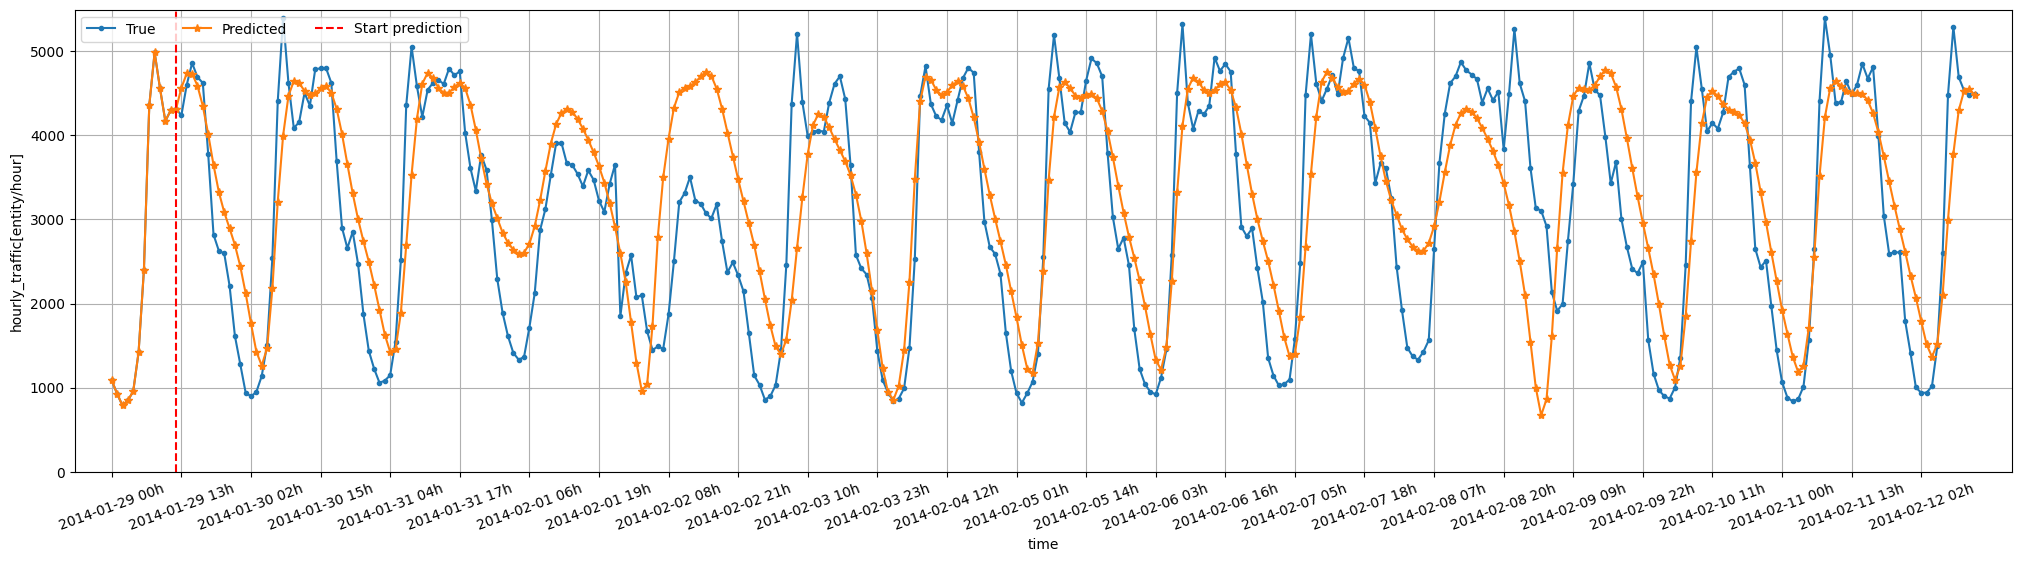

mean_squared_error: 0.2116(0.4600) - mean_absolute_error: 0.3595
DeNorm_mean_squared_error: 685441.5000(827.9139) - DeNorm_mean_absolute_error: 647.0868


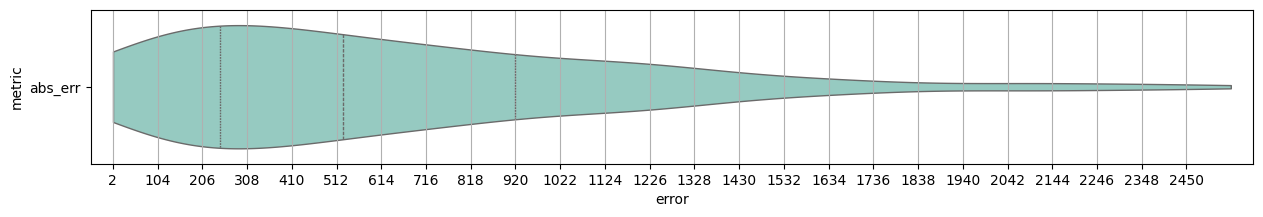

mean         std       min         25%         50%         75%  \
error  647.086776  517.195416  2.402647  246.235675  527.911392  918.817833   

               max  
error  2551.076923

In [ ]:
# log = restore_model()
log = restore_model()
log.pop("Lineare")
log.pop("Conv1D")
for key, model in log.items():
    display(Markdown("---"))
    print(f"\033[01m{key}\033[0m:")

    freeze_not_dense_layer(model)
    fit_model(model, Gen_training_on_another_site_t, 5)
    
    Trainer.free_run_with_plots(
        on_model=model,
        Generator=Gen_test_on_another_site_t,
        plot_range=range_plot,
        folder=path + f"site_{New_site}_Dense_Fit",
    )
del log

##### Training the entire model

---

GRU:


Free-Run: 100%|██████████| 347/347 [00:12<00:00, 28.88it/s]


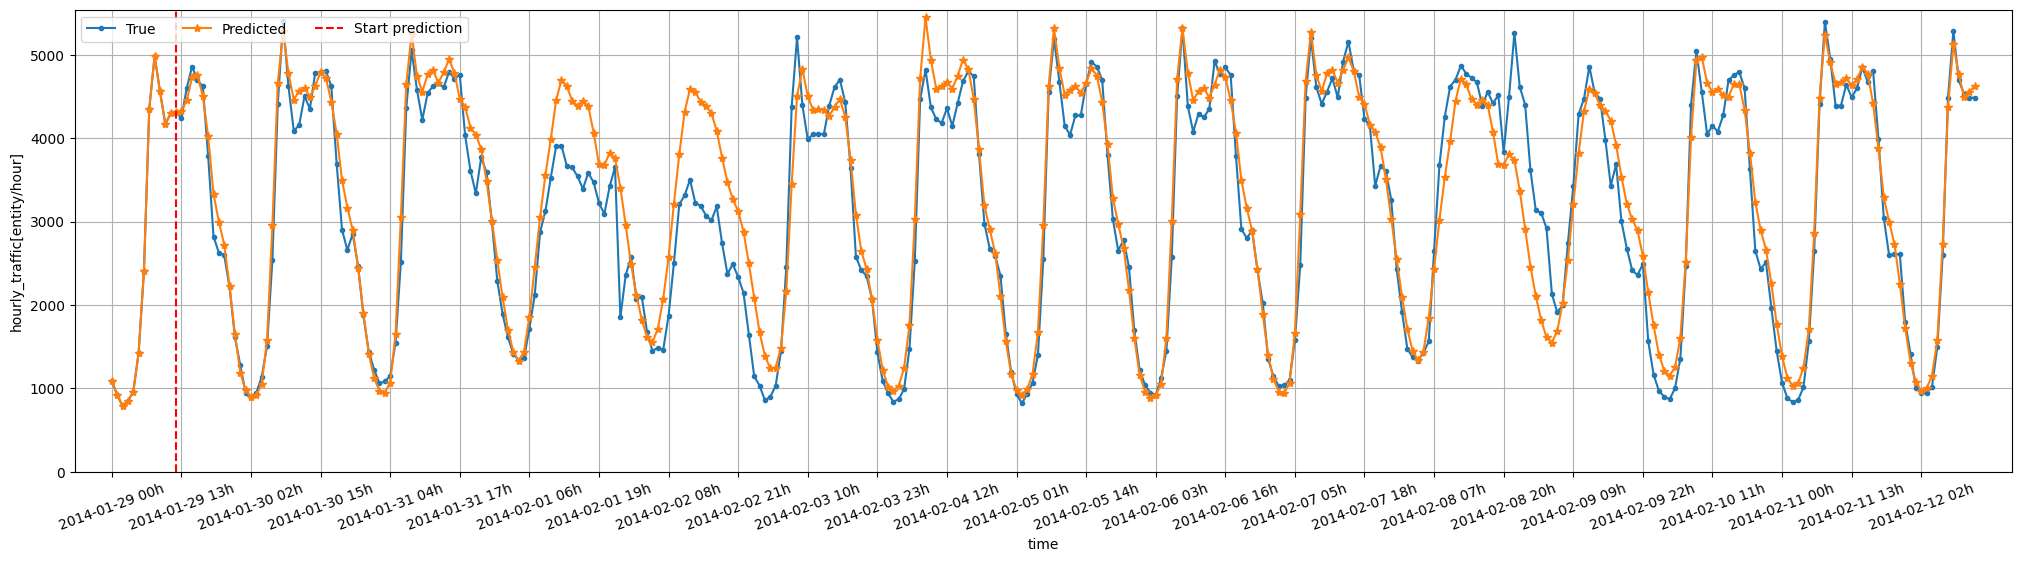

mean_squared_error: 0.0563(0.2373) - mean_absolute_error: 0.1684
DeNorm_mean_squared_error: 182524.9844(427.2294) - DeNorm_mean_absolute_error: 303.0955


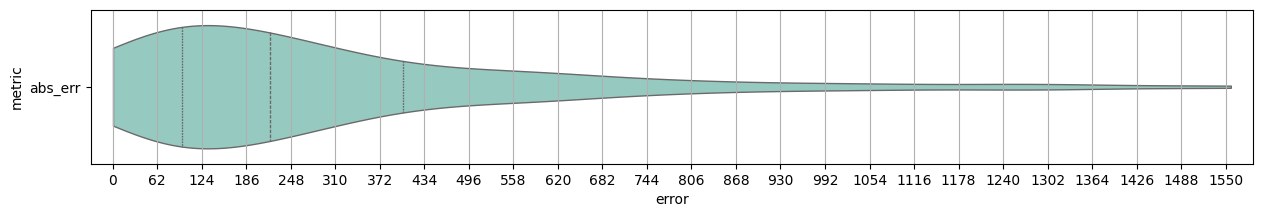

mean         std       min        25%         50%         75%  \
error  303.095518  301.529605  0.341103  96.443087  218.758304  404.092704   

               max  
error  1557.186865

---

un_layer_LSTM:


Free-Run: 100%|██████████| 347/347 [00:11<00:00, 31.39it/s]


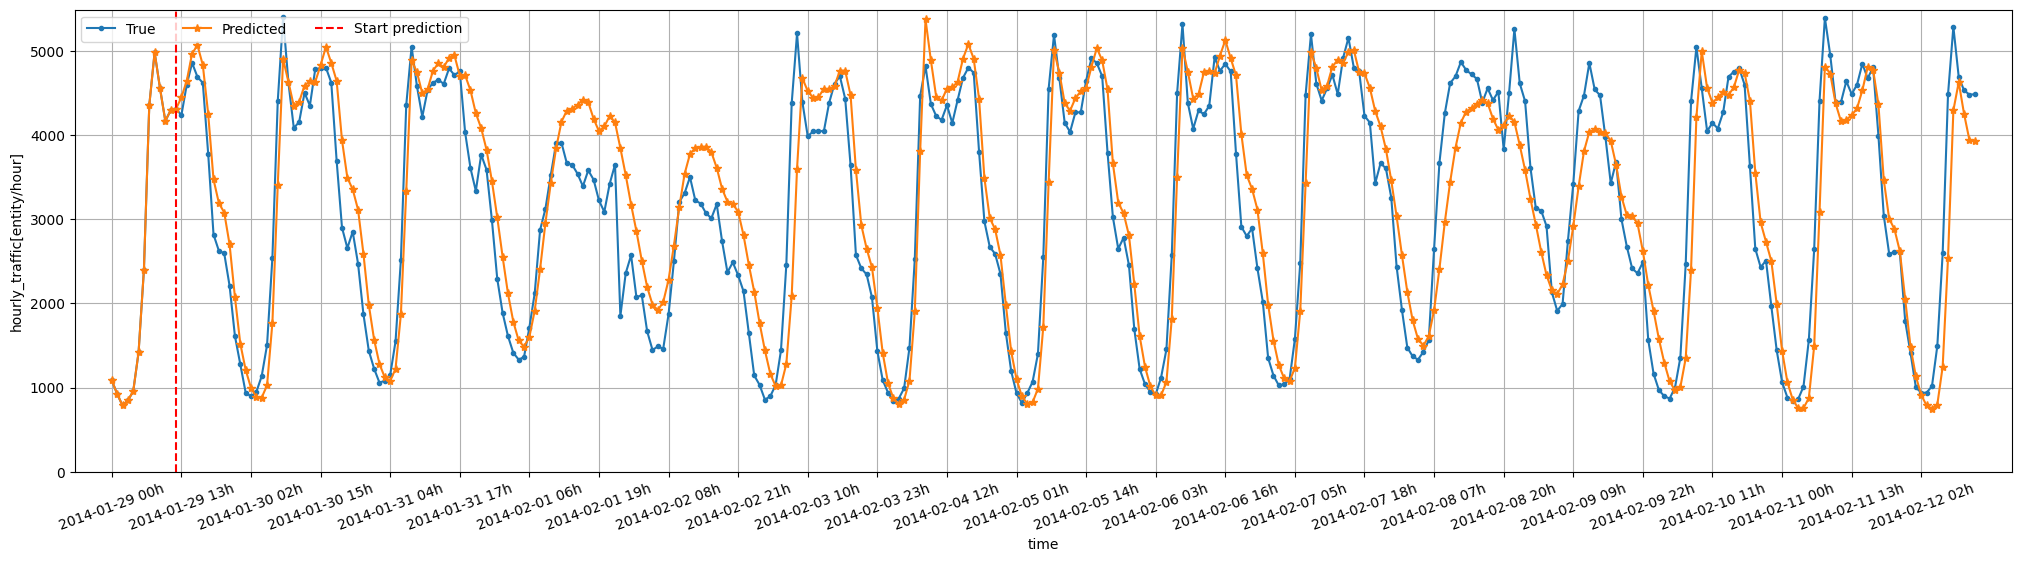

mean_squared_error: 0.0974(0.3121) - mean_absolute_error: 0.2447
DeNorm_mean_squared_error: 315575.8125(561.7614) - DeNorm_mean_absolute_error: 440.4452


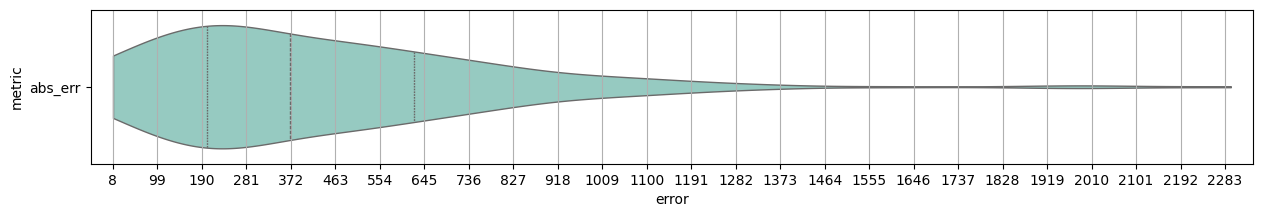

mean         std       min         25%         50%        75%  \
error  440.445174  349.192323  8.314022  199.895776  370.239309  624.97708   

               max  
error  2294.863085

---

Stacked_LSTM:


Free-Run: 100%|██████████| 347/347 [00:19<00:00, 17.56it/s]


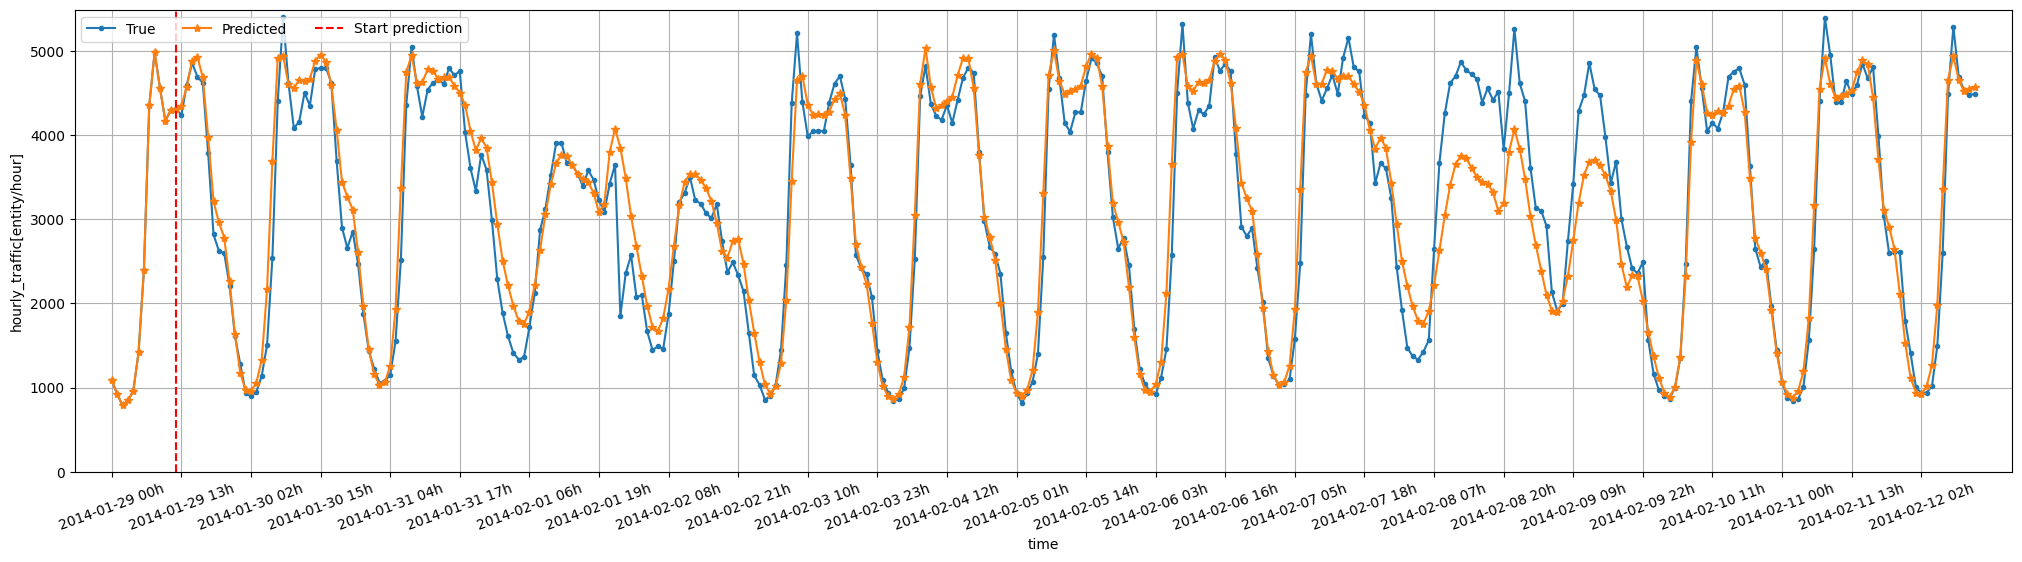

mean_squared_error: 0.0539(0.2322) - mean_absolute_error: 0.1640
DeNorm_mean_squared_error: 174588.2344(417.8376) - DeNorm_mean_absolute_error: 295.2168


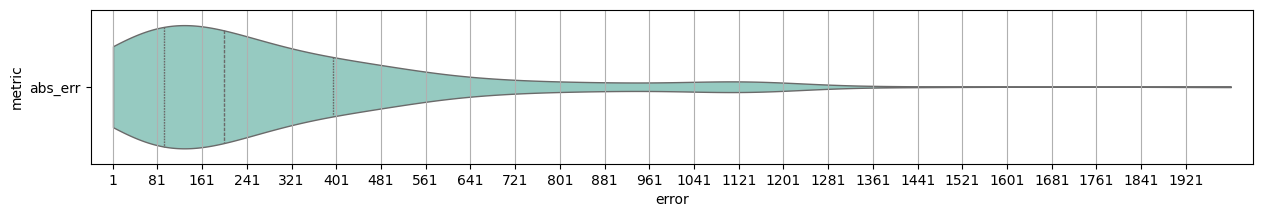

mean         std       min        25%         50%         75%  \
error  295.21685  296.121526  1.673254  93.091444  199.495247  394.399585   

               max  
error  2001.316475

In [46]:
# log = restore_model()
log = restore_model()
log.pop("Lineare")
log.pop("Conv1D")

for key, model in log.items():
    display(Markdown("---"))
    print(f"\033[01m{key}\033[0m:")

    fit_model(model=model, Gen=Gen_training_on_another_site_t, epochs=5)

    path = f"img/{workspace}/{model.name}/"
    os.makedirs(path, exist_ok=True)

    Trainer.free_run_with_plots(
        on_model=model,
        Generator=Gen_test_on_another_site_t,
        plot_range=range_plot,
        folder=path + f"site_{New_site}_Full_Fit",
    )
del log

In [32]:
del (
    imputer_on_another_site,
    epoch,
    Gen_test_on_another_site_t,
    Gen_training_on_another_site_t,
)